<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/Cartpole_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [1]:
!pip install pygame
!pip install highway-env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 3.1 MB/s eta 0:00:00


Testing

In [2]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np


from IPython.display import Image, display
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
%matplotlib inline

Environment Definition

In [3]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

In [4]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs,a):
    self.obs = obs
    self.a = a

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
    # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
    ego_vehicle = env.unwrapped.vehicle
    lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]
    if lead_vehicle:
      gap = lead_vehicle.position[0] - ego_vehicle.position[0]
      delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
      self.longitudinal_lead_state = {"x": gap, "vx": delta_velocity}

    else:
      self.longitudinal_lead_state = {"x": 10, "vx": 0}

    return self.longitudinal_lead_state

  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = lateral acceleration (self.action)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = lateral rate (vy)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    self.target_id = ("0","1",target_id)
    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    w_yaw = (obs[0] * obs[3] - obs[1] * obs[2]) / (obs[0]**2 + obs[1]**2 + 1e-8)
    w_yaw_old = (obs_old[0] * obs_old[3] - obs_old[1] * obs_old[2]) / (obs_old[0]**2 + obs_old[1]**2 + 1e-8)

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]

  #Acceleration to Steering angle
  def steering_angle(self, agent_action,L=1):
    """
    Steering Angle: theta = atan(a_yaw/v^2)
    a_yaw = lateral acceleration (agent_action)
    v = vehicle speed (vx)
    """
    self.angle = math.atan(L*agent_action/self.ego_state_idm()['vx']**2)

    return self.angle

Agent Defintion

In [5]:
class Agent(nn.Module):
  """
  s = (x, y, vx, vy, thetha, lane_width, lane_id, self_curvature, longitudinal_acceleration) ∈ S

  Lateral Agent State:
  x = vehicle x position
  y = vehicle y position
  vx = vehicle speed (longitudinal)
  thetha = yaw angle (heading)
  lane_width = width of the lane
  lane_id = target lane id
  self_curvature = road curvature at the vehicle's position
  longitudinal_acceleration = vehicle longitudinal acceleration
  """
  def __init__(self, state_dim, dim_1 = 100, dim_2 = 150):
    super(Agent, self).__init__()
    self.state_dim = state_dim
    # Define Network A & C
    self.networkA = nn.Sequential(
        nn.Linear(self.state_dim, dim_1),
        nn.Linear(dim_1, 1),
        nn.Softplus()
    )
    self.networkC = nn.Sequential(
        nn.Linear(self.state_dim + 1, dim_1),
        nn.ReLU(),
        nn.Linear(dim_1, 1),
    )

    # Define Network B
    self.networkB1 = nn.Sequential(
        nn.Linear(self.state_dim, dim_2),
        nn.ReLU(),
        nn.Linear(dim_2, 1),
    )
    self.networkB2 = nn.Sequential(
        nn.Linear(self.state_dim, dim_2),
        nn.ReLU(),
        nn.Linear(dim_2, 1),
    )
    self.networkB3 = nn.Sequential(
        nn.Linear(self.state_dim, dim_2),
        nn.ReLU(),
        nn.Linear(dim_2, 1),
    )

  def forward(self, state, a, terminal):
    """
    Q(s,a) = A(s)*(B(s)-a)^2 + C(s)
    """
    if isinstance(state, dict):
      state_tensor = torch.tensor(
          [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32
      ).unsqueeze(0)
    else:
        self.state = state
    # Use a directly if it's already a tensor
    self.a = a if isinstance(a, torch.Tensor) else torch.tensor([[a]], dtype=torch.float32)
    self.terminal_condition = terminal if isinstance(terminal, torch.Tensor) else torch.tensor([[terminal]], dtype=torch.float32)

    # Output of the Networks
    self.A = self.networkA(self.state)
    self.C = self.networkC(torch.concat((self.state, self.terminal_condition), dim=1))
    self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))

    # Q-function Approximation
    q_value =self.A * ((self.B - self.a) ** 2) + self.C

    return q_value

  def action(self, state):
      # Convert it to a tensor
      if isinstance(state, dict):
          state_tensor = torch.tensor(
              [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
              dtype=torch.float32
          ).unsqueeze(0)
      else:
          state_tensor = state
      self.state = state_tensor
      self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))
      return self.B

Experience Buffer

In [6]:
from collections import deque # Ensure imported

class Experience_Buffer():
    """
    Stores transitions as tuples of NumPy arrays (state_vec, action_vec, reward_vec, next_state_vec, terminal_vec).
    """
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=self.buffer_size)

    def add(self, state_vec, action, reward, next_state_vec, terminal_condition):
        state_np = np.asarray(state_vec, dtype=np.float32)
        next_state_np = np.asarray(next_state_vec, dtype=np.float32)
        action_np = np.asarray([action], dtype=np.float32)
        reward_np = np.asarray([reward], dtype=np.float32)
        terminal_np = np.asarray([float(terminal_condition)], dtype=np.float32)

        self.transition = (state_np, action_np, reward_np, next_state_np, terminal_np)
        self.buffer.append(self.transition)

    def sample_experience(self, batch_size, device):
        """ Samples batch and returns Tensors. """
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, terminals = zip(*batch)

        states_np = np.stack(states)
        actions_np = np.stack(actions)
        rewards_np = np.stack(rewards)
        next_states_np = np.stack(next_states)
        terminals_np = np.stack(terminals)

        # Convert final batch arrays to Tensors
        states_tensor = torch.tensor(states_np, dtype=torch.float32, device=device)
        actions_tensor = torch.tensor(actions_np, dtype=torch.float32, device=device)
        rewards_tensor = torch.tensor(rewards_np, dtype=torch.float32, device=device)
        next_states_tensor = torch.tensor(next_states_np, dtype=torch.float32, device=device)
        terminals_tensor = torch.tensor(terminals_np, dtype=torch.float32, device=device)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, terminals_tensor

    def size(self):
        return len(self.buffer)

Lateral Controller (Gap Checker)

In [7]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Longitudinal Controller

In [8]:
class IDM():
    ''' Intelligent Driving Model for Longitudinal Control

    Control parameters:
      a: maximum acceleration
      b: comfortable deceleration
      delta: acceleration exponent
      T: safe time headway

    Parameters:
      s0: minimum gap
      v0: desired speed

      a (Maximum Acceleration): How fast the vehicle can speed up (m/s²).
      b (Comfortable Deceleration): How smoothly the vehicle slows down (m/s²).
      δ (Acceleration Exponent): The non-linearity factor in acceleration.
      T (Safe Time Headway): The desired minimum following time gap (s).

    Input variables:
      s: current gap
      v: current vehicle speed
      delta_v: relative speed (difference between the vehicle's speed and the leading vehicle's speed)
    '''

    def __init__(self, desired_parameters, control_parameters):
        # Unpack initial parameters: [s0, v0]
        self.s0, self.v0 = desired_parameters
        # Unpack control parameters: [a, b, delta, T]
        self.a, self.b, self.delta, self.T = control_parameters

    def longitudinal_controller(self, input_variables):
        # Unpack input variables: [s, v, delta_v]
        s, v, delta_v = input_variables

        # Small epsilon to account for very small gaps and avoid division by zero
        epsilon = 1e-6

        # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
        desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

        # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
        acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

        return acceleration

State Normalization

In [9]:
import numpy as np
import torch

# --- Define these globally or pass them to the normalizer ---
# MUST match the order expected by the Agent input and feature extraction
STATE_KEYS_ORDER = ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha',
                    'lane_id', 'lane_width', 'self_curvature']
STATE_DIM = len(STATE_KEYS_ORDER)
# ---------------------------------------------------------

class StateNormalizer:
    """
    Computes running mean and standard deviation for state normalization (Z-score).
    Uses Welford's online algorithm for numerical stability.
    Includes methods to handle dictionary inputs.
    """
    def __init__(self, size=STATE_DIM, epsilon=1e-5, clip_range=5.0, device='cpu'):
        """
        Initializes the normalizer.

        Args:
            size (int): The dimension of the state vector (should match STATE_DIM).
            epsilon (float): Small value to prevent division by zero in std dev.
            clip_range (float): Range [-clip_range, clip_range] to clip normalized states.
            device (str or torch.device): The device to put output tensors on.
        """
        if size != STATE_DIM:
            raise ValueError(f"Normalizer size ({size}) does not match expected STATE_DIM ({STATE_DIM})")
        self.size = size
        self.epsilon = epsilon
        self.clip_range = clip_range
        self.device = torch.device(device) # Store device

        # Welford's algorithm variables
        self.count = 0
        self.mean = np.zeros(self.size, dtype=np.float32)
        self.M2 = np.zeros(self.size, dtype=np.float32)

    def _state_dict_to_vector(self, state_dict):
        """Converts the state dictionary to a NumPy vector."""
        # Internal helper, could also be a static method or defined outside
        if state_dict is None:
            # Return zeros or raise error? Let's return zeros for now.
            print("Warning: Received None state_dict, returning zero vector.")
            return np.zeros(self.size, dtype=np.float32)
        try:
            # Ensure all keys exist before list comprehension
            for key in STATE_KEYS_ORDER:
                if key not in state_dict:
                    raise KeyError(f"Missing key '{key}'")
            state_vector = np.array([state_dict[key] for key in STATE_KEYS_ORDER], dtype=np.float32)
            return state_vector
        except KeyError as e:
            raise KeyError(f"Missing key {e} in state dictionary for normalization. Available keys: {list(state_dict.keys())}")
        except Exception as e:
            raise ValueError(f"Error converting state dict to vector: {e}")

    def update_from_dict(self, state_dict):
        """
        Updates the running mean and M2 using a new state dictionary.

        Args:
            state_dict (dict): A single state dictionary.
        """
        state_vector = self._state_dict_to_vector(state_dict)
        # Now use the existing update logic with the vector
        self.count += 1
        delta = state_vector - self.mean
        self.mean += delta / self.count
        delta2 = state_vector - self.mean
        self.M2 += delta * delta2

    def _get_stddev(self):
        """Calculates the current standard deviation."""
        if self.count < 2:
            return np.ones(self.size, dtype=np.float32)
        variance = self.M2 / (self.count -1) # Sample variance
        stddev = np.sqrt(np.maximum(variance, self.epsilon**2)) # Use epsilon^2 with sqrt
        # Ensure stddev is not exactly zero
        stddev = np.maximum(stddev, self.epsilon)
        return stddev

    def normalize_dict_to_tensor(self, state_dict):
        """
        Converts a state dictionary to a NumPy vector, normalizes it,
        clips it, and returns it as a Tensor on the specified device.
        Does NOT update running statistics.

        Args:
            state_dict (dict): The state dictionary to normalize.

        Returns:
            torch.Tensor: The normalized state as a Tensor [1, state_dim].
        """
        state_vector = self._state_dict_to_vector(state_dict)

        mean_tensor = torch.tensor(self.mean, dtype=torch.float32, device=self.device)
        stddev_tensor = torch.tensor(self._get_stddev(), dtype=torch.float32, device=self.device)
        state_tensor = torch.tensor(state_vector, dtype=torch.float32, device=self.device)

        # Normalize: (state - mean) / stddev
        normalized_tensor = (state_tensor - mean_tensor) / stddev_tensor

        # Clip and add batch dimension
        clipped_tensor = torch.clamp(normalized_tensor, -self.clip_range, self.clip_range).unsqueeze(0)

        return clipped_tensor

    def normalize_batch_tensor(self, state_batch_tensor):
        """
        Normalizes a batch of state vectors already in Tensor format.
        Used during learning update after sampling from buffer.
        Does NOT update running statistics.

        Args:
            state_batch_tensor (torch.Tensor): Batch of state vectors [batch_size, state_dim].

        Returns:
            torch.Tensor: The normalized batch of states, clipped.
        """
        if not isinstance(state_batch_tensor, torch.Tensor):
             state_batch_tensor = torch.tensor(state_batch_tensor, dtype=torch.float32, device=self.device)

        mean_tensor = torch.tensor(self.mean, dtype=torch.float32, device=self.device)
        stddev_tensor = torch.tensor(self._get_stddev(), dtype=torch.float32, device=self.device)

        # Ensure tensors are on the same device as the input batch
        mean_tensor = mean_tensor.to(state_batch_tensor.device)
        stddev_tensor = stddev_tensor.to(state_batch_tensor.device)


        # Normalize: (batch_state - mean) / stddev (broadcasting applies)
        normalized_batch = (state_batch_tensor - mean_tensor) / stddev_tensor

        # Clip
        clipped_batch = torch.clamp(normalized_batch, -self.clip_range, self.clip_range)

        return clipped_batch

    # --- Optional: Load/Save ---
    def get_state(self):
        return {'count': self.count, 'mean': self.mean.tolist(), 'M2': self.M2.tolist()} # Save as lists

    def set_state(self, state_dict):
        self.count = state_dict['count']
        self.mean = np.array(state_dict['mean'], dtype=np.float32)
        self.M2 = np.array(state_dict['M2'], dtype=np.float32)

Initialize Environment

In [10]:
# Initialize Environment
obs, _ = env.reset()

# Initialize Environment Manager and Reward
state_manager = ENV(obs,obs[0][2])

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

# Initial Longitundinal Positions
ego_position_idm = ego_state_idm['x']
lead_position_idm = lead_state['x']

# Initial Velocities (using vx for longitudinal control)
ego_velocity_idm = ego_state_idm['vx']
lead_velocity_idm = lead_state['vx']

Training Loop

CartPole (Test)

Starting training for CartPole-v1 - 500 episodes
Device: cuda, State dim: 4, Actions: 2
Network dimensions: 16, 32
Exploration epsilon: 0.9 → 0.05 over 10000 steps
Ep    1/500 │ Steps:  27 │ Ep Return:   27.00 │ Avg Return (100 ep):   27.00 │ Epsilon:0.898 │ Buffer:    27 │ Loss:N/A
Ep    2/500 │ Steps:  19 │ Ep Return:   19.00 │ Avg Return (100 ep):   23.00 │ Epsilon:0.896 │ Buffer:    46 │ Loss:N/A
Ep    3/500 │ Steps:  21 │ Ep Return:   21.00 │ Avg Return (100 ep):   22.33 │ Epsilon:0.894 │ Buffer:    67 │ Loss:N/A
Ep    4/500 │ Steps:  30 │ Ep Return:   30.00 │ Avg Return (100 ep):   24.25 │ Epsilon:0.892 │ Buffer:    97 │ Loss:N/A
Ep    5/500 │ Steps:  34 │ Ep Return:   34.00 │ Avg Return (100 ep):   26.20 │ Epsilon:0.889 │ Buffer:   131 │ Loss:N/A
Ep    6/500 │ Steps:  30 │ Ep Return:   30.00 │ Avg Return (100 ep):   26.83 │ Epsilon:0.886 │ Buffer:   161 │ Loss:N/A
Ep    7/500 │ Steps:  18 │ Ep Return:   18.00 │ Avg Return (100 ep):   25.57 │ Epsilon:0.885 │ Buffer:   179 │ Loss:

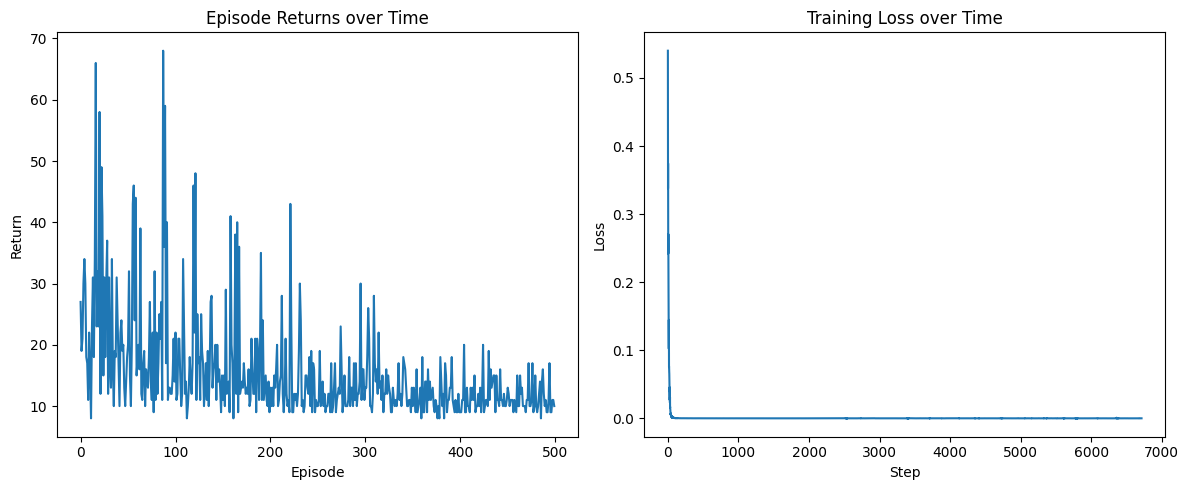

In [17]:
# ────────────────────────────────  ENV  ───────────────────────────────────────
env_name = "CartPole-v1"
env = gymnasium.make(env_name, render_mode=None)
state_dim = env.observation_space.shape[0]  # 4 (cart position, cart velocity, pole angle, pole angular velocity)
action_dim = env.action_space.n  # 2 actions (left, right)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────  HYPERPARAMETERS  ───────────────────────────────────────
gamma = 0.99
batch_size = 128
num_episodes = 500
max_steps_per_episode = 500  # CartPole default
lr = 1e-2
replay_buffer_size = 10000
min_replay_size = 1000
plot_every = 10
dim_1 = 16
dim_2 = 32

# --- Soft Update Parameters ---
tau = 0.0005  # Target network soft update parameter

# --- Exploration Parameters ---
epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay_steps = 10000

epsilon_decay_rate = (epsilon_start - epsilon_end) / epsilon_decay_steps
epsilon = epsilon_start

episode_returns = []
loss_history = []
global_step = 0

# ─────────────────────────────  NETWORKS  ─────────────────────────────────────
policy_net = Agent(state_dim, dim_1, dim_2).to(device)
target_net = Agent(state_dim, dim_1, dim_2).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# ────────────────────────────  REPLAY BUFFER  ─────────────────────────────────
class ReplayBuf:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)

    def add(self, s, a, r, s2, d):
        s_tensor = s.squeeze(0).cpu()
        s2_tensor = s2.squeeze(0).cpu()
        self.buf.append((s_tensor, a, r, s2_tensor, d))

    def sample(self, n):
        if len(self.buf) < n: return None
        batch = random.sample(self.buf, n)

        s, a, r, s2, d = zip(*batch)
        s_batch = torch.stack(s).to(device)
        a_batch = torch.tensor(a, dtype=torch.float32, device=device).unsqueeze(1)
        r_batch = torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1)
        s2_batch = torch.stack(s2).to(device)
        d_batch = torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1)
        return s_batch, a_batch, r_batch, s2_batch, d_batch

    def __len__(self):
        return len(self.buf)

replay = ReplayBuf(replay_buffer_size)

# ─────────────────── SOFT UPDATE FUNCTION ────────────────────────────────
def soft_update(target, source, tau):
    """
    Perform soft update of target network parameters
    target = (1-tau)*target + tau*source
    """
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            (1.0 - tau) * target_param.data + tau * source_param.data
        )

# ─────────────────────────── TRAINING LOOP ────────────────────────────────────
print(f"Starting training for CartPole-v1 - {num_episodes} episodes")
print(f"Device: {device}, State dim: {state_dim}, Actions: {action_dim}")
print(f"Network dimensions: {dim_1}, {dim_2}")
print(f"Exploration epsilon: {epsilon_start} → {epsilon_end} over {epsilon_decay_steps} steps")

for ep in range(1, num_episodes + 1):
    obs, _ = env.reset()
    state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
    done = False
    steps = 0
    ep_ret = 0.0
    last_step_loss = None
    policy_net.train()

    while not done and steps < max_steps_per_episode:
        steps += 1
        global_step += 1

        # Epsilon-greedy exploration
        if random.random() < epsilon:
            action_val = env.action_space.sample()
        else:
            # This is the action selection from the original code
            with torch.no_grad():
                b_value = policy_net.action(state).item()
            action_val = 1/(1+np.exp(-b_value))  # Convert to probability using sigmoid
            action_val = 1 if action_val > 0.5 else 0  # Threshold to get discrete action

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon - epsilon_decay_rate)

        # Take action in environment
        obs2, reward, terminated, truncated, _ = env.step(action_val)
        done = terminated or truncated
        ep_ret += reward

        next_state = torch.tensor(obs2, dtype=torch.float32).unsqueeze(0).to(device)
        replay.add(state, float(action_val), float(reward), next_state, float(done))
        state = next_state

        if len(replay) >= min_replay_size:
            sample = replay.sample(batch_size)
            if sample is None: continue
            s_b, a_b, r_b, s2_b, d_b = sample
            q_curr_b = policy_net(s_b, a_b, d_b)

            with torch.no_grad():
                # Use the same action selection pattern as in the original code
                q_next_act = target_net.action(s2_b)
                q_next_val = target_net(s2_b, q_next_act, d_b)
                q_target_b = r_b + gamma * q_next_val * (1 - d_b)

            loss = loss_fn(q_curr_b, q_target_b)
            last_step_loss = loss.item()
            loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Apply soft update to target network after each learning step
            soft_update(target_net, policy_net, tau)

        if done:
            break

    episode_returns.append(ep_ret)
    avg_return = np.mean(episode_returns[-100:]) if len(episode_returns) >= 100 else np.mean(episode_returns)
    loss_str_repr = f"{last_step_loss:.4f}" if last_step_loss is not None else "N/A"

    print(f"Ep {ep:4}/{num_episodes} │ Steps:{steps:4} │ Ep Return:{ep_ret:8.2f} "
          f"│ Avg Return (100 ep):{avg_return:8.2f} │ Epsilon:{epsilon:.3f} "
          f"│ Buffer:{len(replay):6} │ Loss:{loss_str_repr}")

    # Save plots periodically
    if ep % plot_every == 0:
        plt.figure(figsize=(12, 5))

        # Plot episode returns
        plt.subplot(1, 2, 1)
        plt.plot(episode_returns)
        plt.xlabel("Episode")
        plt.ylabel("Return")
        plt.title("Episode Returns over Time")

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(loss_history)
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Training Loss over Time")

        plt.tight_layout()
        plt.savefig(f"cartpole_plot_ep{ep}.png")
        plt.close()

# Final plots
plt.figure(figsize=(12, 5))

# Plot episode returns
plt.subplot(1, 2, 1)
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Episode Returns over Time")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Time")

plt.tight_layout()
plt.savefig("cartpole_final_plot.png")
plt.show()

env.close()

Always Active (Option 1)

Starting training loop...
Device: cpu, Buffer Size: 10000, Batch Size: 64
Epsilon Start: 0.5, Epsilon End: 0.05, Decay Steps: 10000
Learning Rate: 0.01, Gamma: 0.99
SOFT UPDATES: Tau = 0.0005, Update Frequency: 1 steps
Max Timesteps: 40000
Video Recording: Every 5000 steps

Buffer filled with 64 experiences. Starting Q-learning updates...

Ep   1 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:   400/40000 | Ep Return: -354.15 | Avg Return: -354.15 | Reward/Step: -0.885±0.396 | Epsilon: 0.482 | Buffer:   400 | Loss: 0.07150917500257492
Ep   2 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:   800/40000 | Ep Return: -576.32 | Avg Return: -465.24 | Reward/Step: -1.441±0.500 | Epsilon: 0.464 | Buffer:   800 | Loss: 0.0676867738366127
Step:  1000/40000 | Recent Avg Loss: 0.056849 | Epsilon: 0.455
Ep   3 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:  1200/40000 | Ep Return: -557.16 | Avg Return: -495.88 | Reward/Step: -1.393±0.427 | Epsilon: 0.446 | Buffer:  1200 | Loss: 0.08417294919490

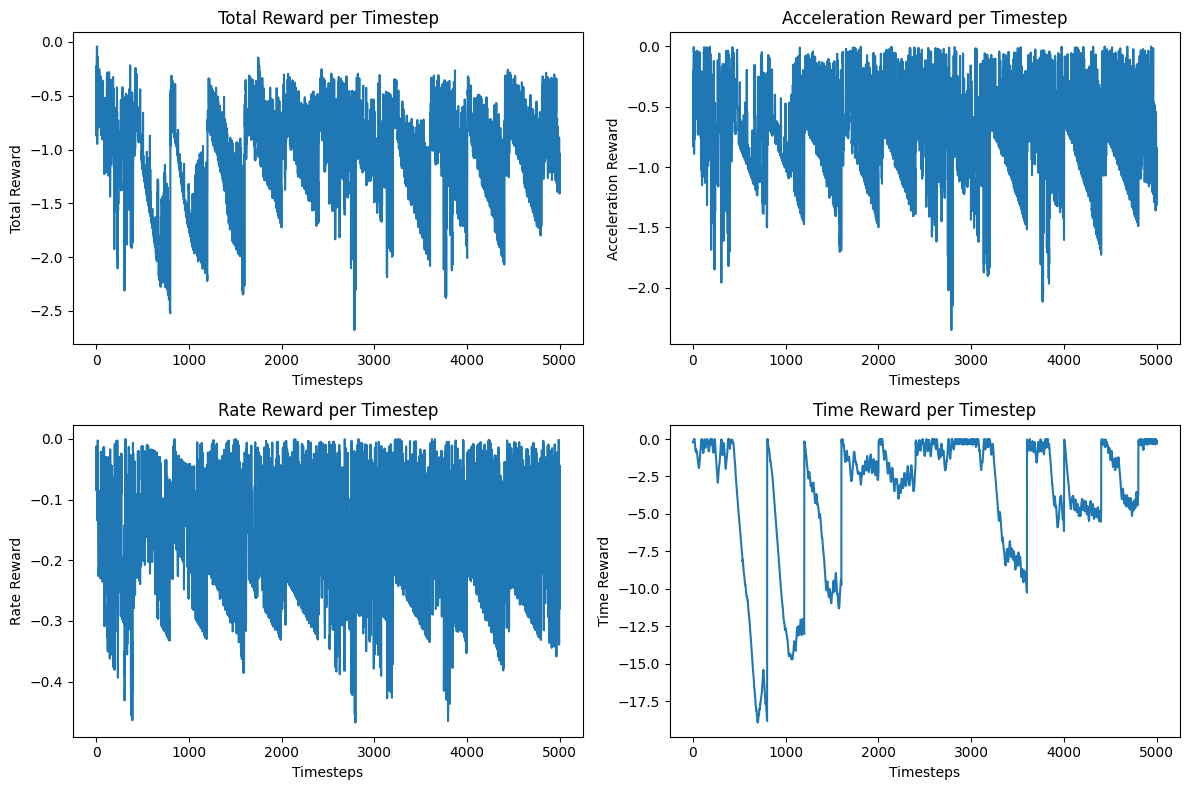

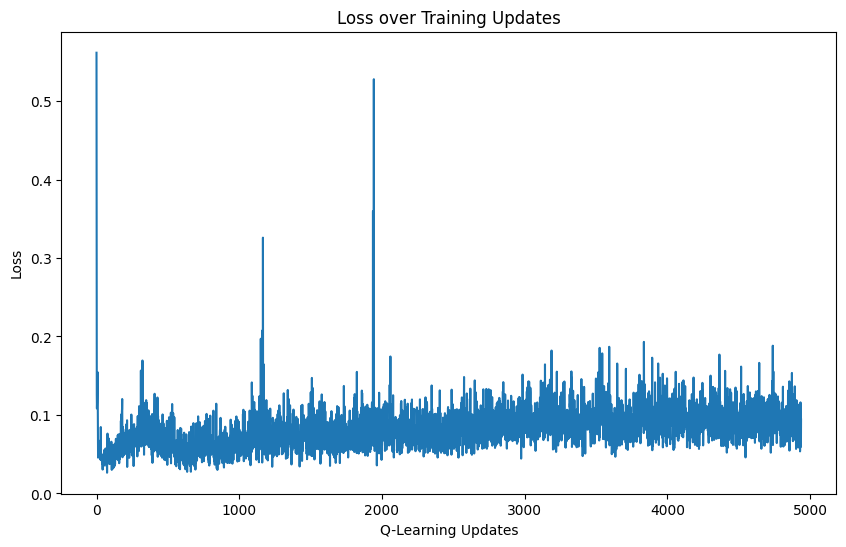

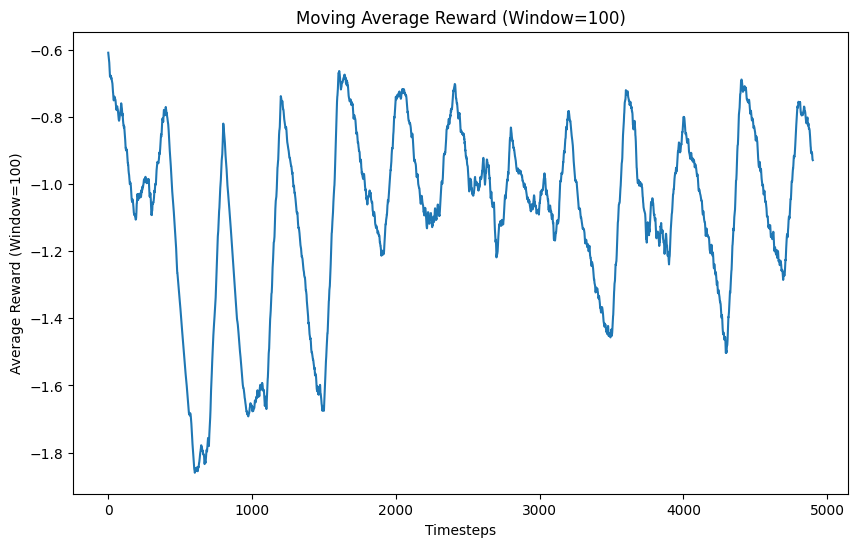

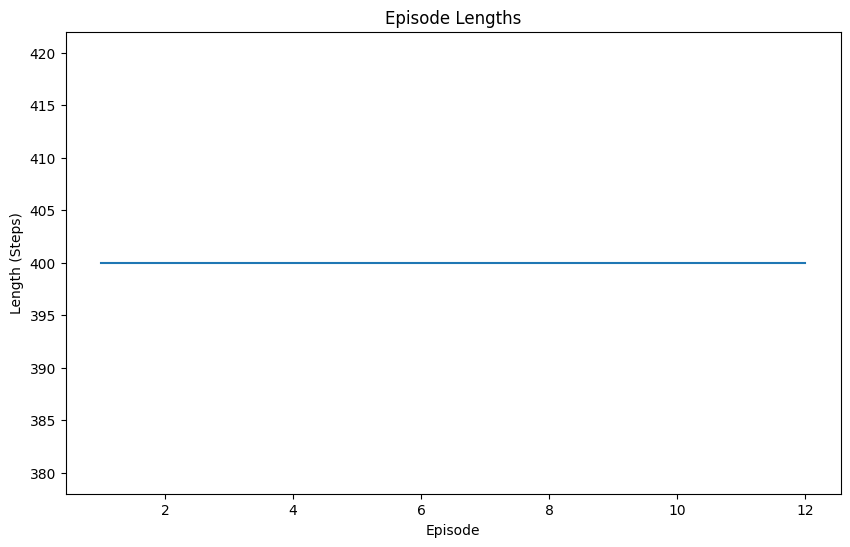

Plots saved at timestep 5000
Ep  13 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:  5200/40000 | Ep Return: -434.00 | Avg Return: -435.68 | Reward/Step: -1.085±0.428 | Epsilon: 0.266 | Buffer:  5200 | Loss: 0.07376513630151749
Ep  14 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:  5600/40000 | Ep Return: -387.97 | Avg Return: -432.27 | Reward/Step: -0.970±0.417 | Epsilon: 0.248 | Buffer:  5600 | Loss: 0.08098852634429932
Step:  6000/40000 | Recent Avg Loss: 0.102382 | Epsilon: 0.230
Ep  15 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:  6000/40000 | Ep Return: -396.02 | Avg Return: -429.86 | Reward/Step: -0.990±0.375 | Epsilon: 0.230 | Buffer:  6000 | Loss: 0.08067037165164948
Ep  16 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:  6400/40000 | Ep Return: -384.25 | Avg Return: -427.01 | Reward/Step: -0.961±0.348 | Epsilon: 0.212 | Buffer:  6400 | Loss: 0.11283772438764572
Ep  17 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps:  6800/40000 | Ep Return: -409.96 | Avg Return: -426.

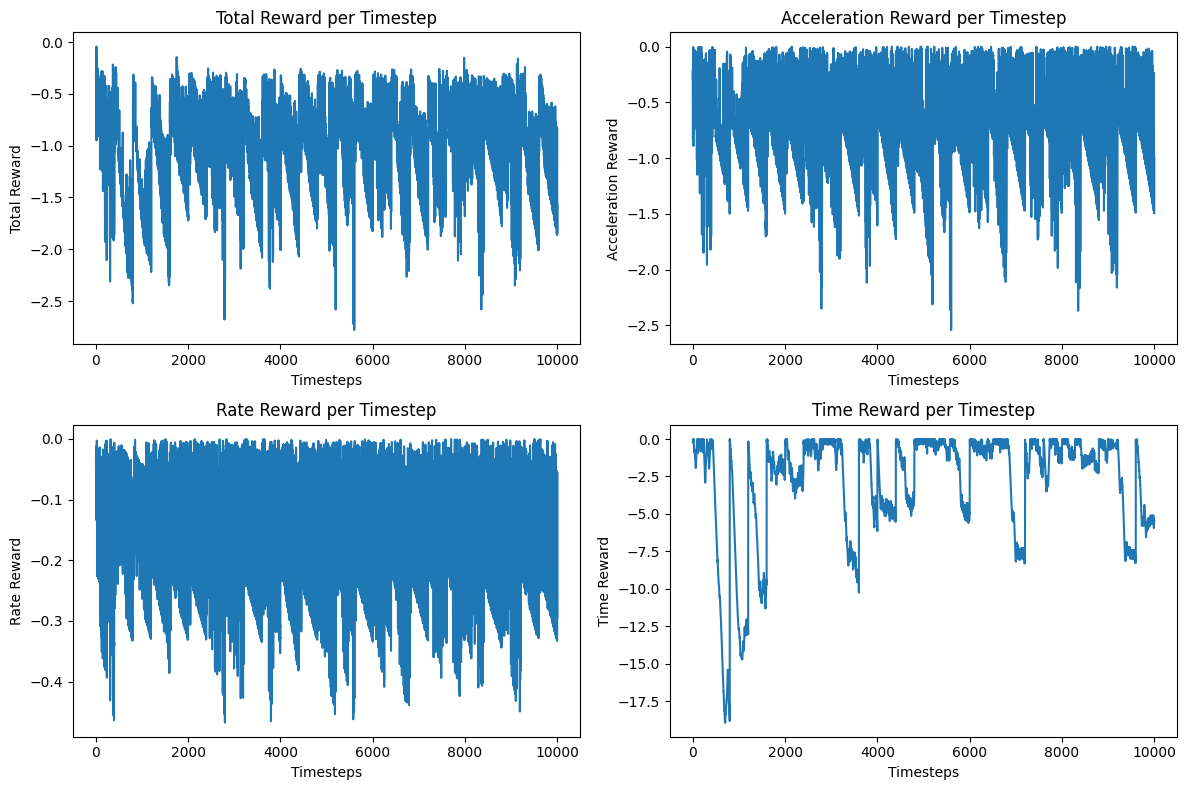

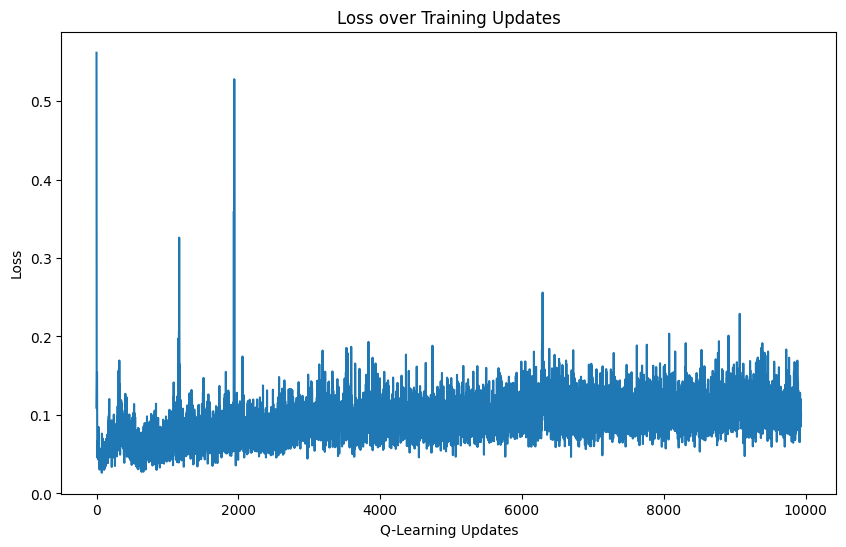

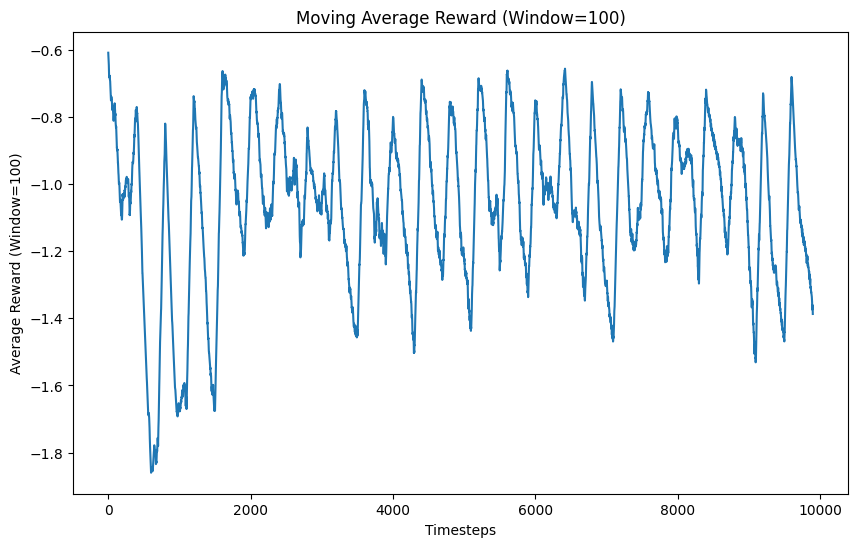

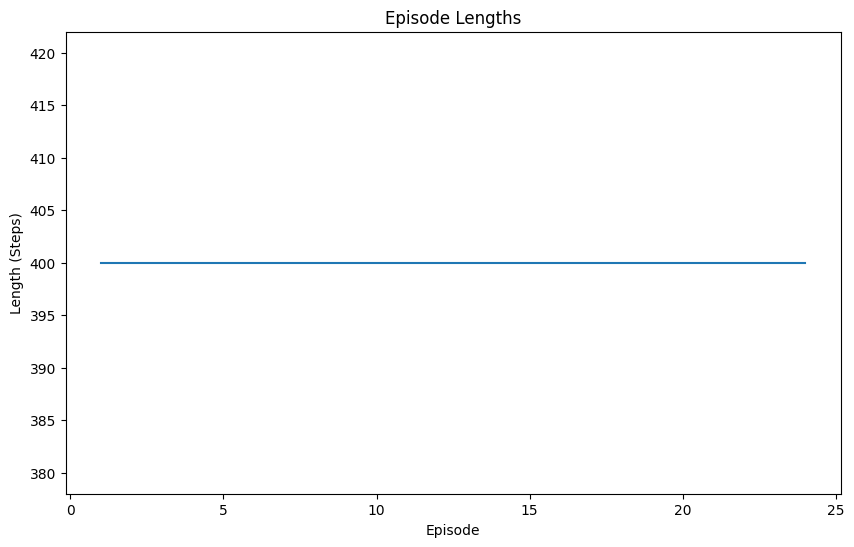

Plots saved at timestep 10000
Ep  25 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 10000/40000 | Ep Return: -432.23 | Avg Return: -423.55 | Reward/Step: -1.081±0.364 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.1027132049202919
Ep  26 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 10400/40000 | Ep Return: -378.05 | Avg Return: -421.80 | Reward/Step: -0.945±0.329 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.11342769861221313
Ep  27 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 10800/40000 | Ep Return: -394.26 | Avg Return: -420.78 | Reward/Step: -0.986±0.431 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.09926292300224304
Step: 11000/40000 | Recent Avg Loss: 0.117485 | Epsilon: 0.050
Ep  28 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 11200/40000 | Ep Return: -385.10 | Avg Return: -419.51 | Reward/Step: -0.963±0.347 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.10051673650741577
Ep  29 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 11600/40000 | Ep Return: -437.76 | Avg Return: -420.

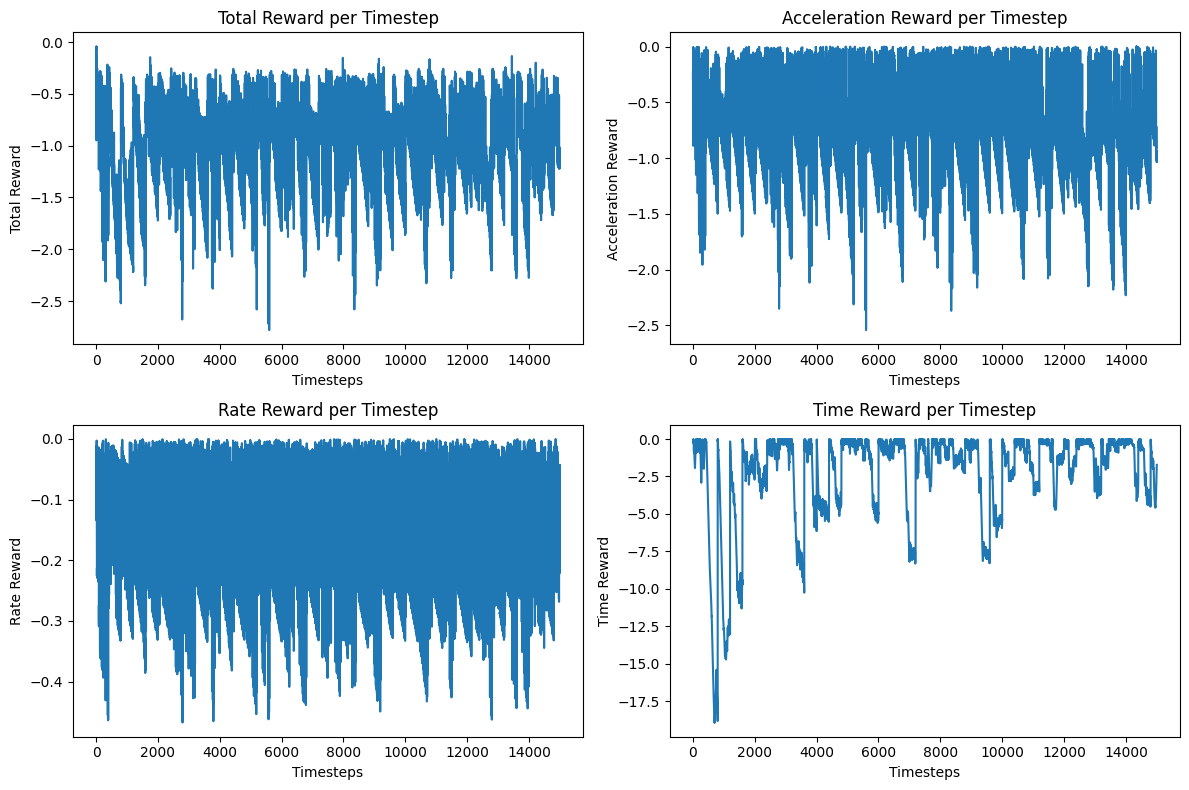

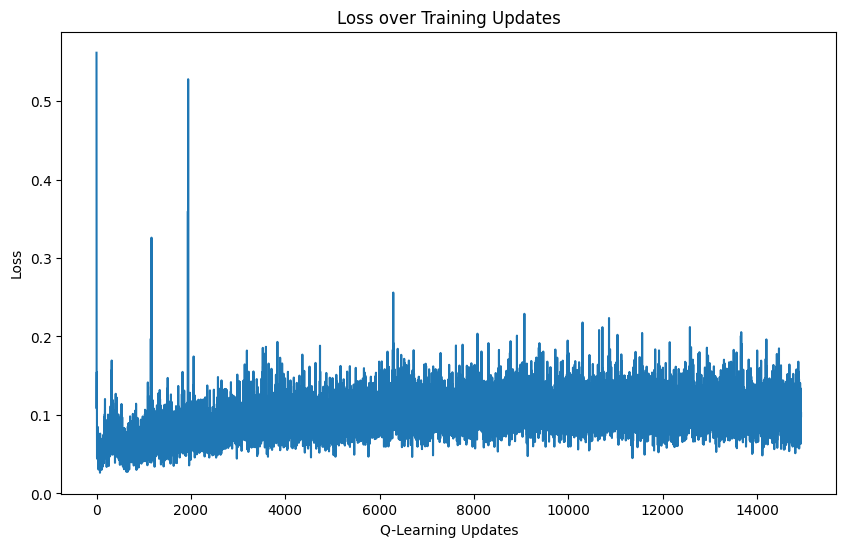

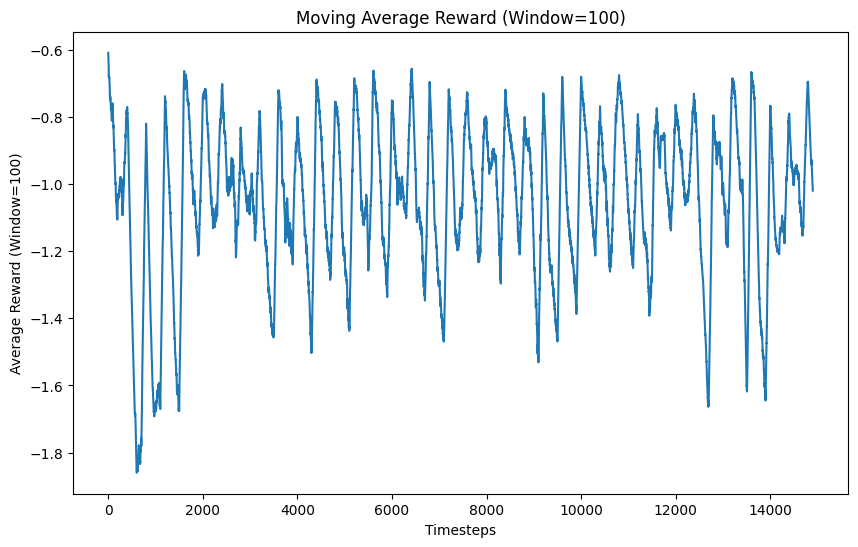

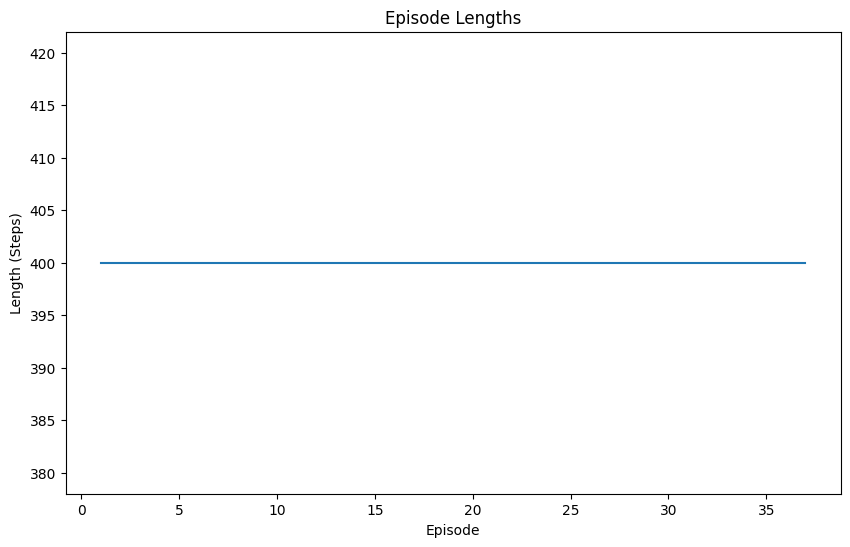

Plots saved at timestep 15000
Ep  38 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 15200/40000 | Ep Return: -413.82 | Avg Return: -418.50 | Reward/Step: -1.035±0.329 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.07674390077590942
Ep  39 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 15600/40000 | Ep Return: -444.98 | Avg Return: -419.18 | Reward/Step: -1.112±0.436 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.13264404237270355
Step: 16000/40000 | Recent Avg Loss: 0.095080 | Epsilon: 0.050
Ep  40 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 16000/40000 | Ep Return: -385.64 | Avg Return: -418.34 | Reward/Step: -0.964±0.333 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.10438007116317749
Ep  41 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 16400/40000 | Ep Return: -371.44 | Avg Return: -417.20 | Reward/Step: -0.929±0.336 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.14648135006427765
Ep  42 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 16800/40000 | Ep Return: -440.53 | Avg Return: -417

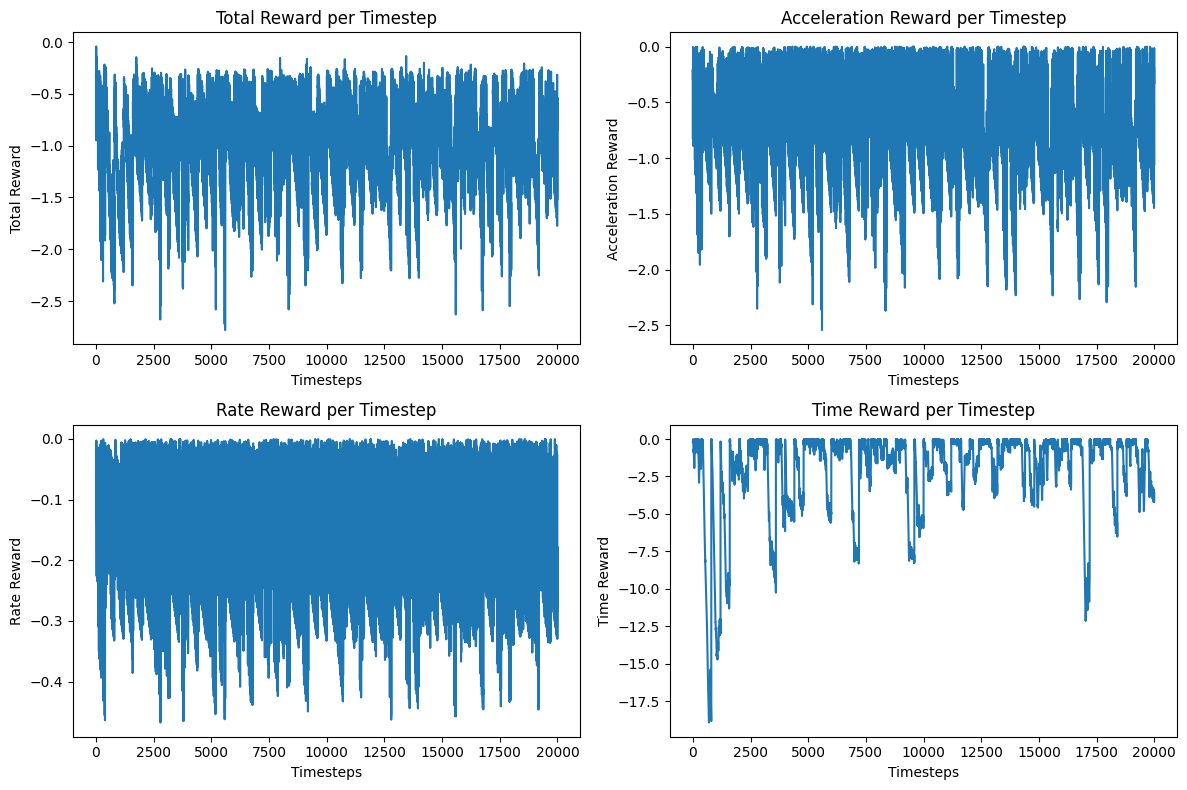

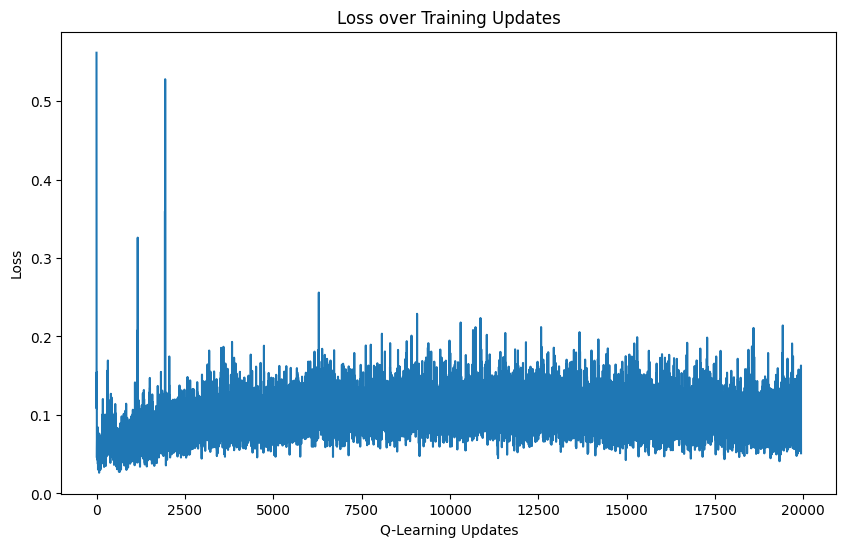

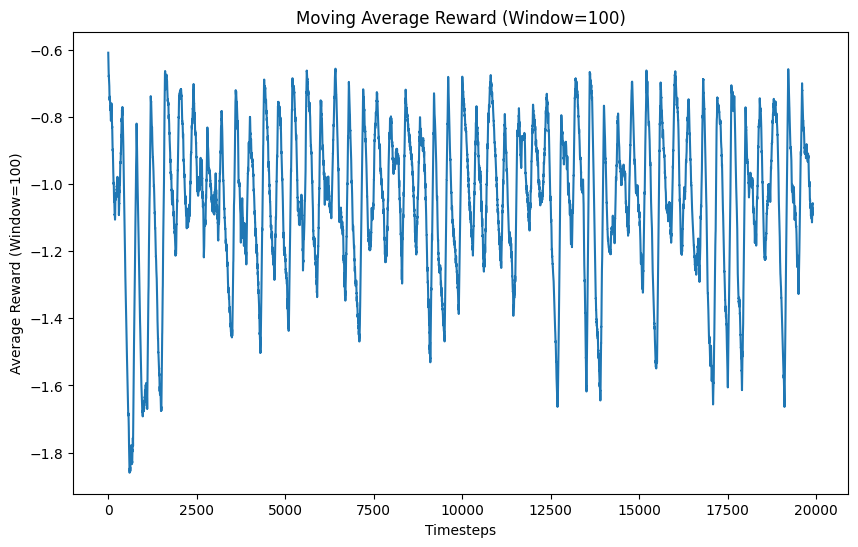

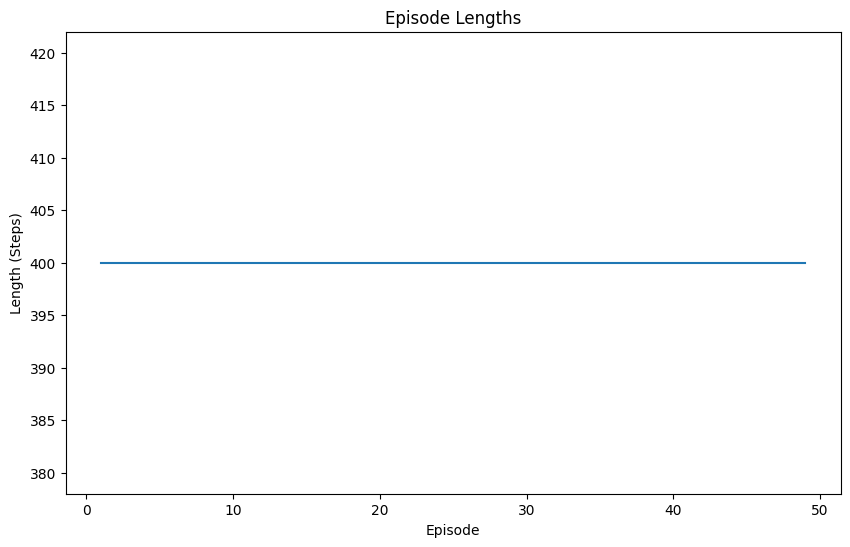

Plots saved at timestep 20000
Ep  50 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 20000/40000 | Ep Return: -368.53 | Avg Return: -418.92 | Reward/Step: -0.921±0.309 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.05115268751978874
Ep  51 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 20400/40000 | Ep Return: -435.79 | Avg Return: -419.25 | Reward/Step: -1.089±0.411 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.07586462050676346
Ep  52 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 20800/40000 | Ep Return: -496.18 | Avg Return: -420.73 | Reward/Step: -1.240±0.614 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.11241832375526428
Step: 21000/40000 | Recent Avg Loss: 0.095705 | Epsilon: 0.050
Ep  53 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 21200/40000 | Ep Return: -427.03 | Avg Return: -420.85 | Reward/Step: -1.068±0.347 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.0729815736413002
Ep  54 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 21600/40000 | Ep Return: -512.98 | Avg Return: -422.

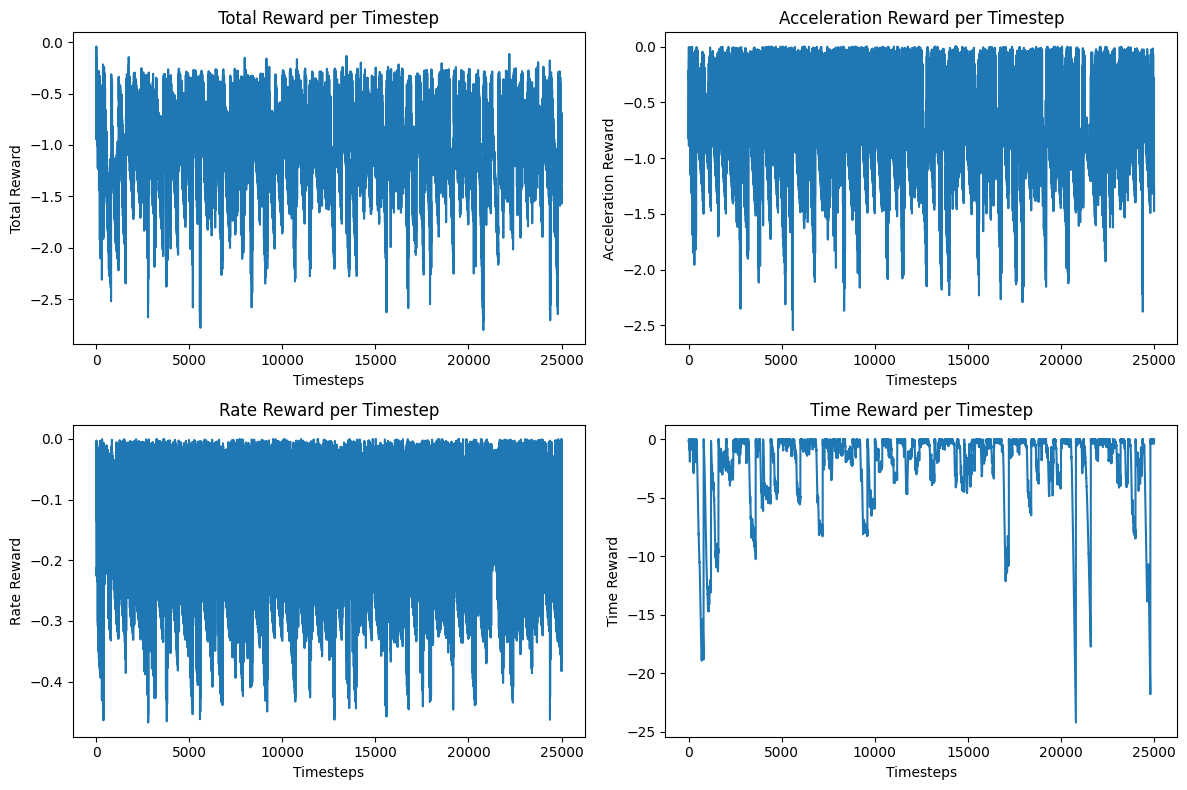

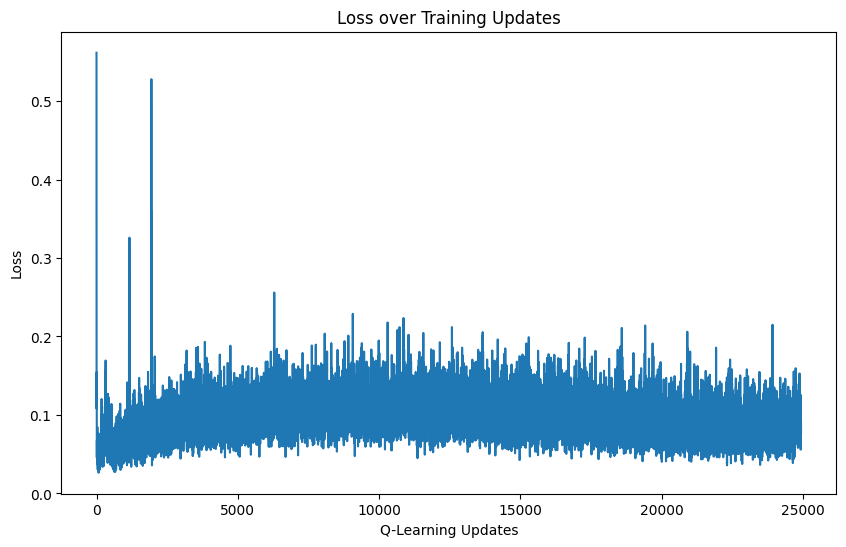

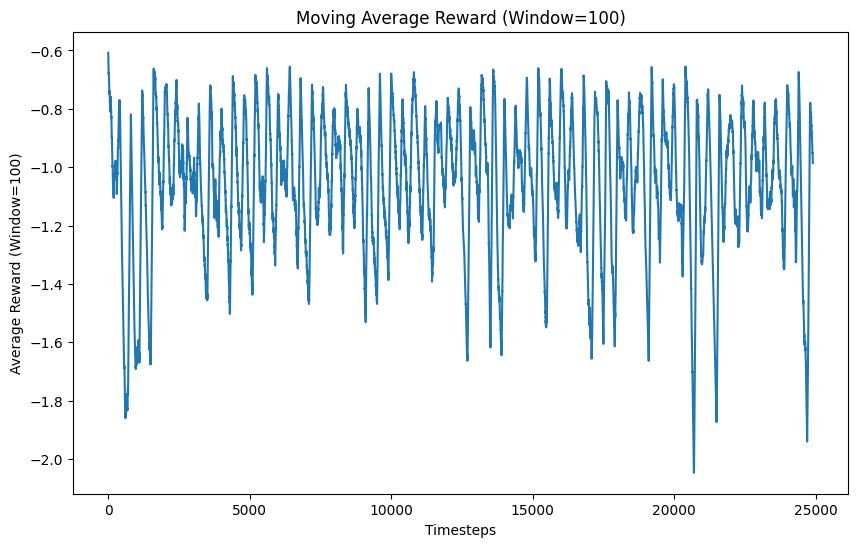

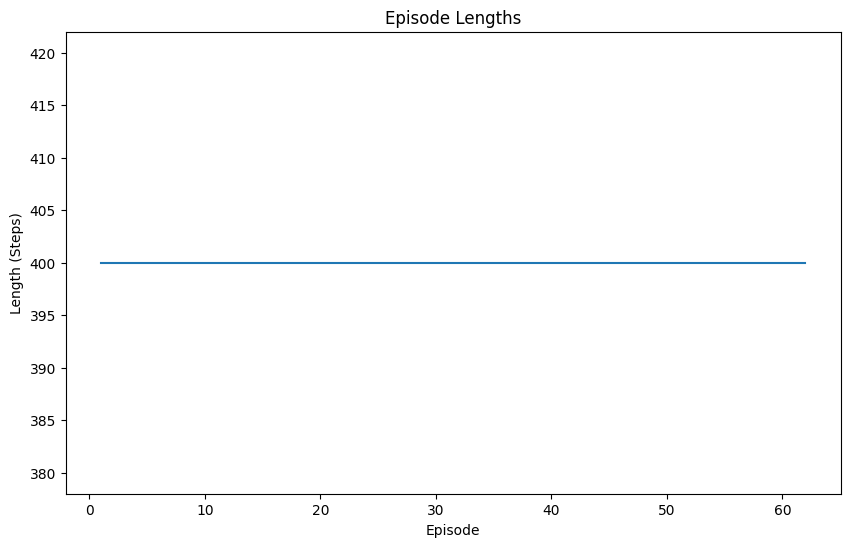

Plots saved at timestep 25000
Ep  63 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 25200/40000 | Ep Return: -456.31 | Avg Return: -422.80 | Reward/Step: -1.141±0.415 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.09289169311523438
Ep  64 | Steps:  400 | Avg Ep Len: 400.0 | Total Steps: 25600/40000 | Ep Return: -372.41 | Avg Return: -422.01 | Reward/Step: -0.931±0.332 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.06210555508732796
Ep  65 | Steps:   60 | Avg Ep Len: 394.8 | Total Steps: 25660/40000 | Ep Return: -48.42 | Avg Return: -416.26 | Reward/Step: -0.807±0.157 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.12199714779853821
Step: 26000/40000 | Recent Avg Loss: 0.090582 | Epsilon: 0.050
Ep  66 | Steps:  400 | Avg Ep Len: 394.8 | Total Steps: 26060/40000 | Ep Return: -574.63 | Avg Return: -418.66 | Reward/Step: -1.437±0.509 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.1252422332763672
Ep  67 | Steps:  400 | Avg Ep Len: 394.9 | Total Steps: 26460/40000 | Ep Return: -414.97 | Avg Return: -418.6

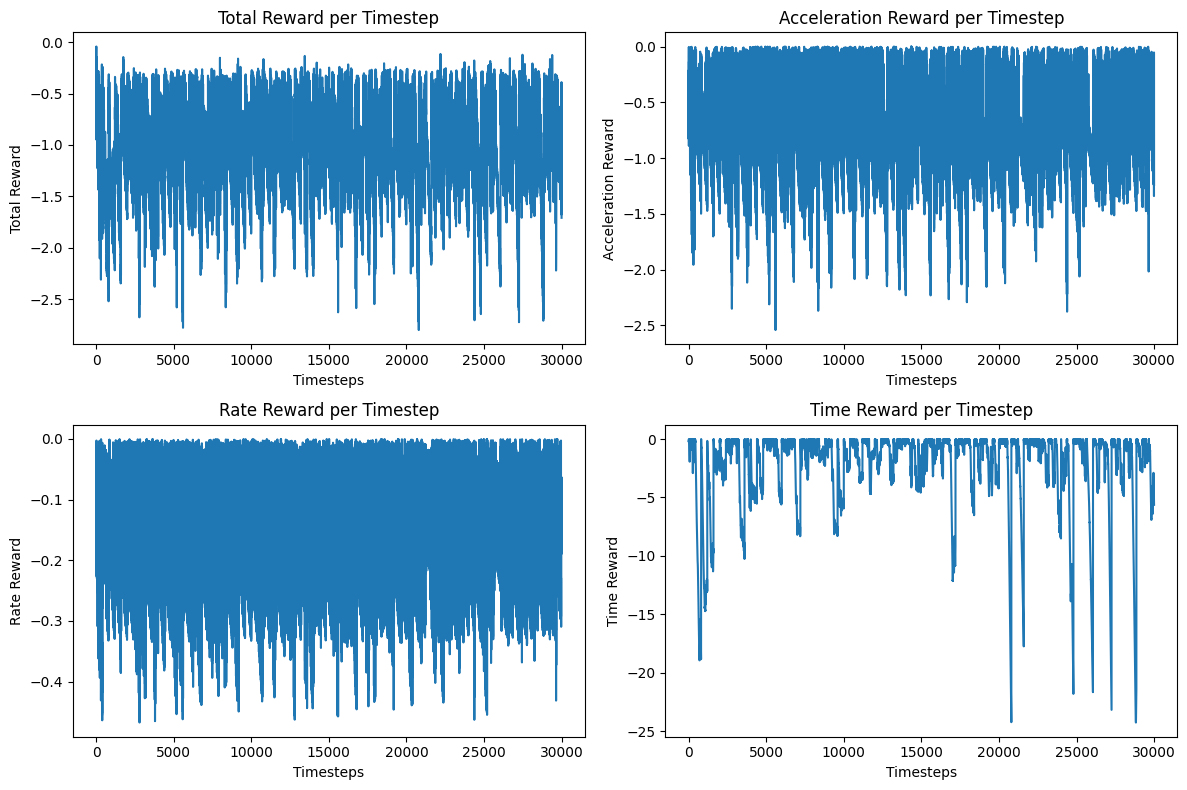

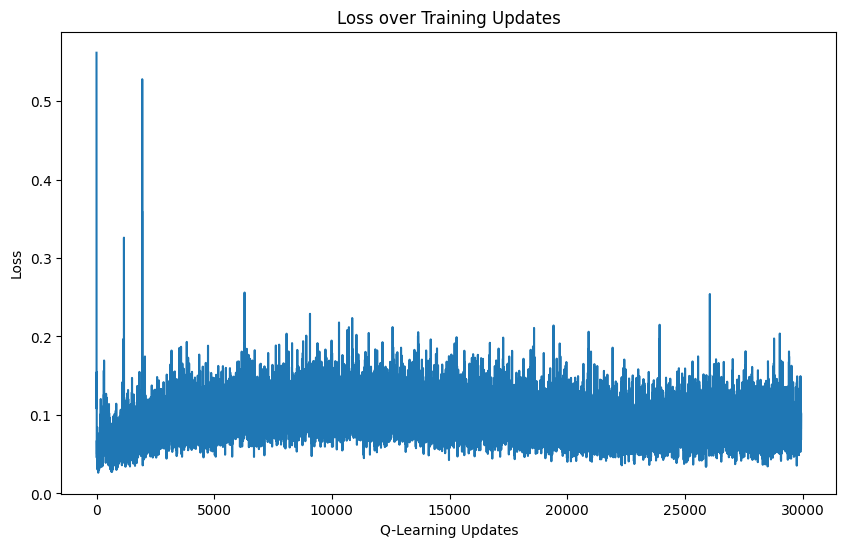

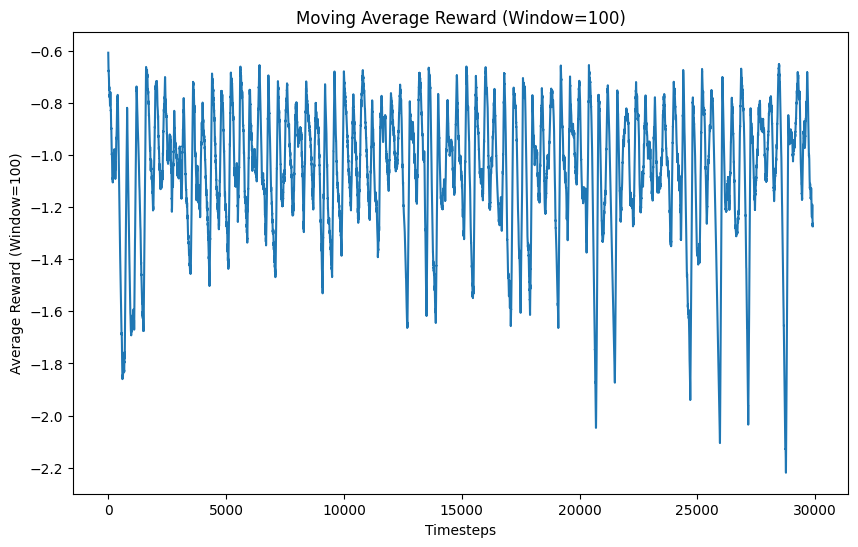

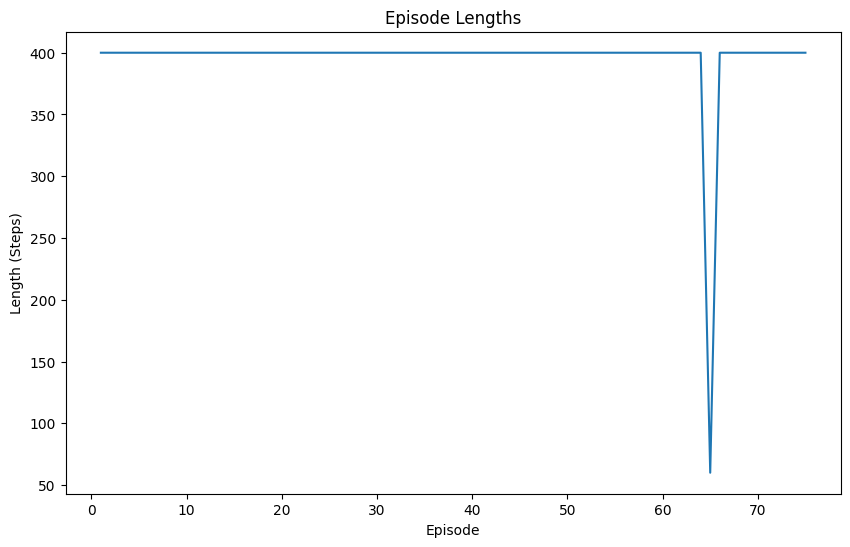

Plots saved at timestep 30000
Ep  76 | Steps:  400 | Avg Ep Len: 395.5 | Total Steps: 30060/40000 | Ep Return: -430.50 | Avg Return: -418.77 | Reward/Step: -1.076±0.347 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.10504673421382904
Ep  77 | Steps:  400 | Avg Ep Len: 395.6 | Total Steps: 30460/40000 | Ep Return: -565.77 | Avg Return: -420.68 | Reward/Step: -1.414±0.567 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.05170596018433571
Ep  78 | Steps:  162 | Avg Ep Len: 392.6 | Total Steps: 30622/40000 | Ep Return: -137.04 | Avg Return: -417.04 | Reward/Step: -0.846±0.140 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.08130528032779694
Step: 31000/40000 | Recent Avg Loss: 0.086261 | Epsilon: 0.050
Ep  79 | Steps:  400 | Avg Ep Len: 392.7 | Total Steps: 31022/40000 | Ep Return: -407.83 | Avg Return: -416.93 | Reward/Step: -1.020±0.302 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.0668446347117424
Ep  80 | Steps:  400 | Avg Ep Len: 392.8 | Total Steps: 31422/40000 | Ep Return: -567.31 | Avg Return: -418.

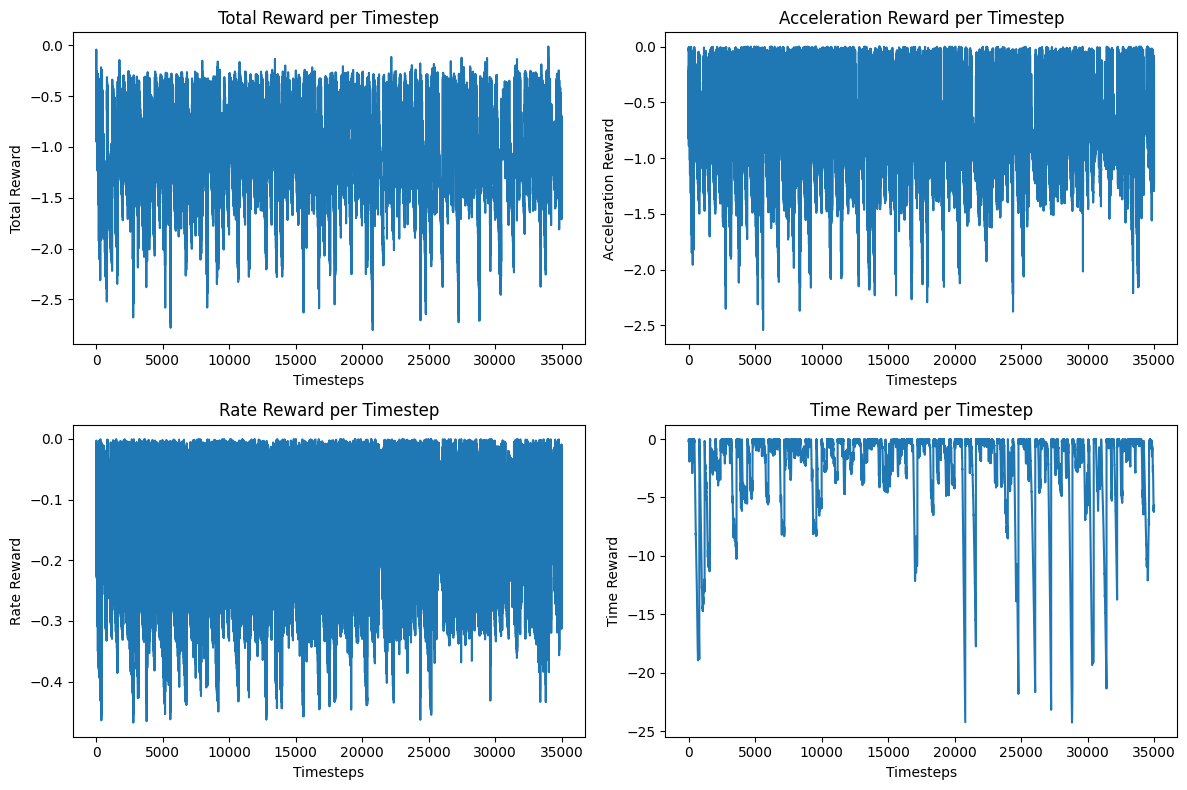

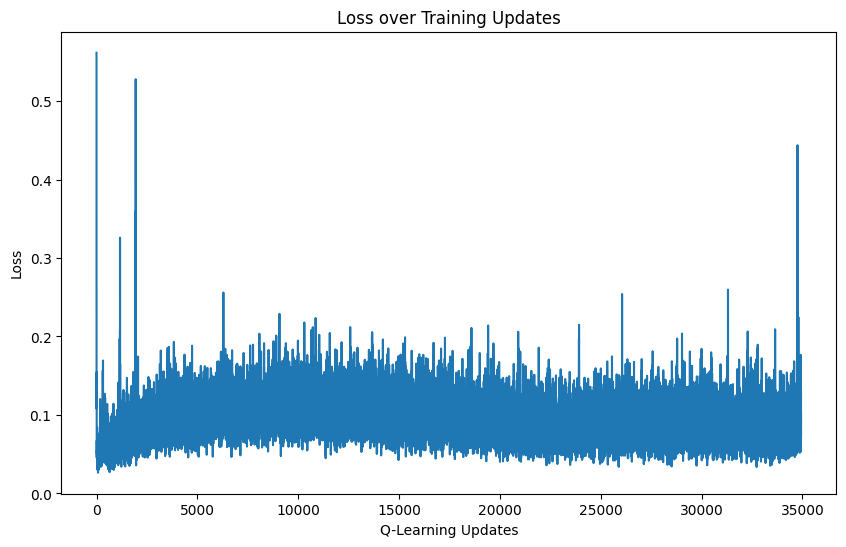

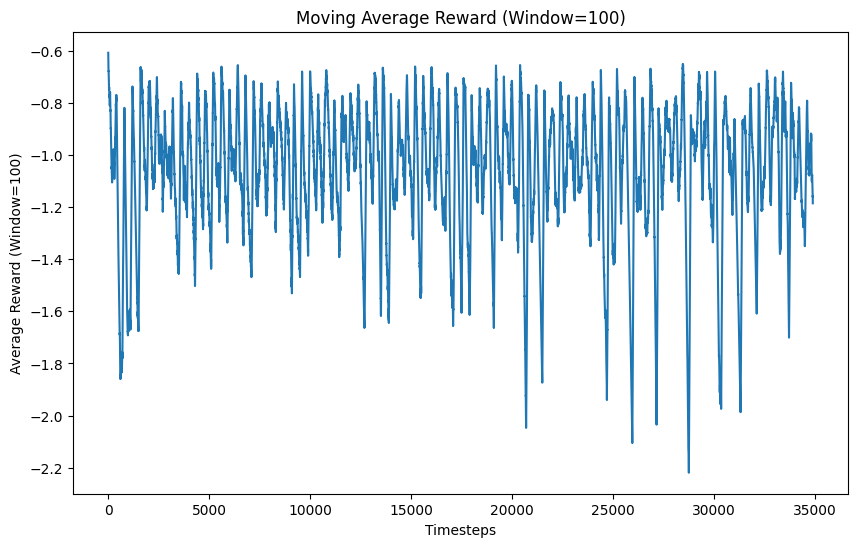

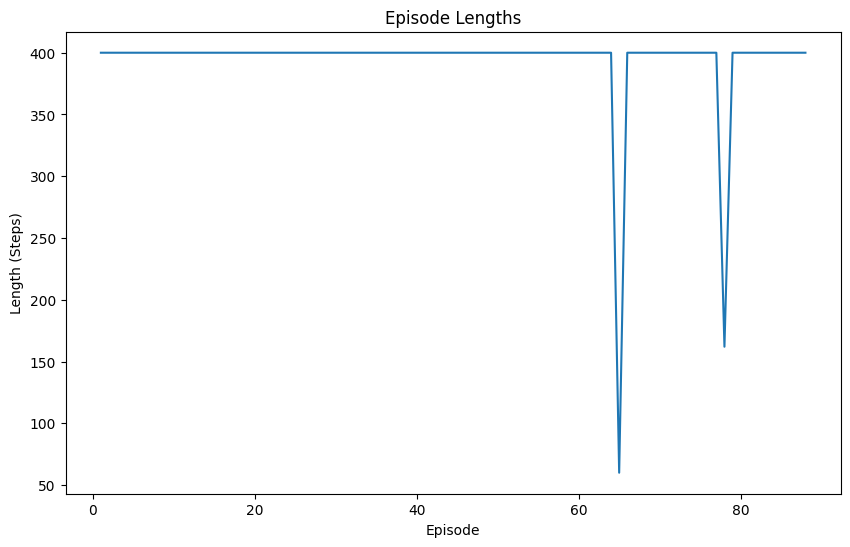

Plots saved at timestep 35000
Ep  89 | Steps:  400 | Avg Ep Len: 393.5 | Total Steps: 35022/40000 | Ep Return: -404.05 | Avg Return: -417.83 | Reward/Step: -1.010±0.305 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.05781877785921097
Ep  90 | Steps:  400 | Avg Ep Len: 393.6 | Total Steps: 35422/40000 | Ep Return: -456.88 | Avg Return: -418.26 | Reward/Step: -1.142±0.373 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.06961307674646378
Ep  91 | Steps:  400 | Avg Ep Len: 393.6 | Total Steps: 35822/40000 | Ep Return: -421.10 | Avg Return: -418.30 | Reward/Step: -1.053±0.330 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.07051068544387817
Step: 36000/40000 | Recent Avg Loss: 0.082776 | Epsilon: 0.050
Ep  92 | Steps:  400 | Avg Ep Len: 393.7 | Total Steps: 36222/40000 | Ep Return: -431.74 | Avg Return: -418.44 | Reward/Step: -1.079±0.308 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.06808432936668396
Ep  93 | Steps:  400 | Avg Ep Len: 393.8 | Total Steps: 36622/40000 | Ep Return: -349.36 | Avg Return: -417

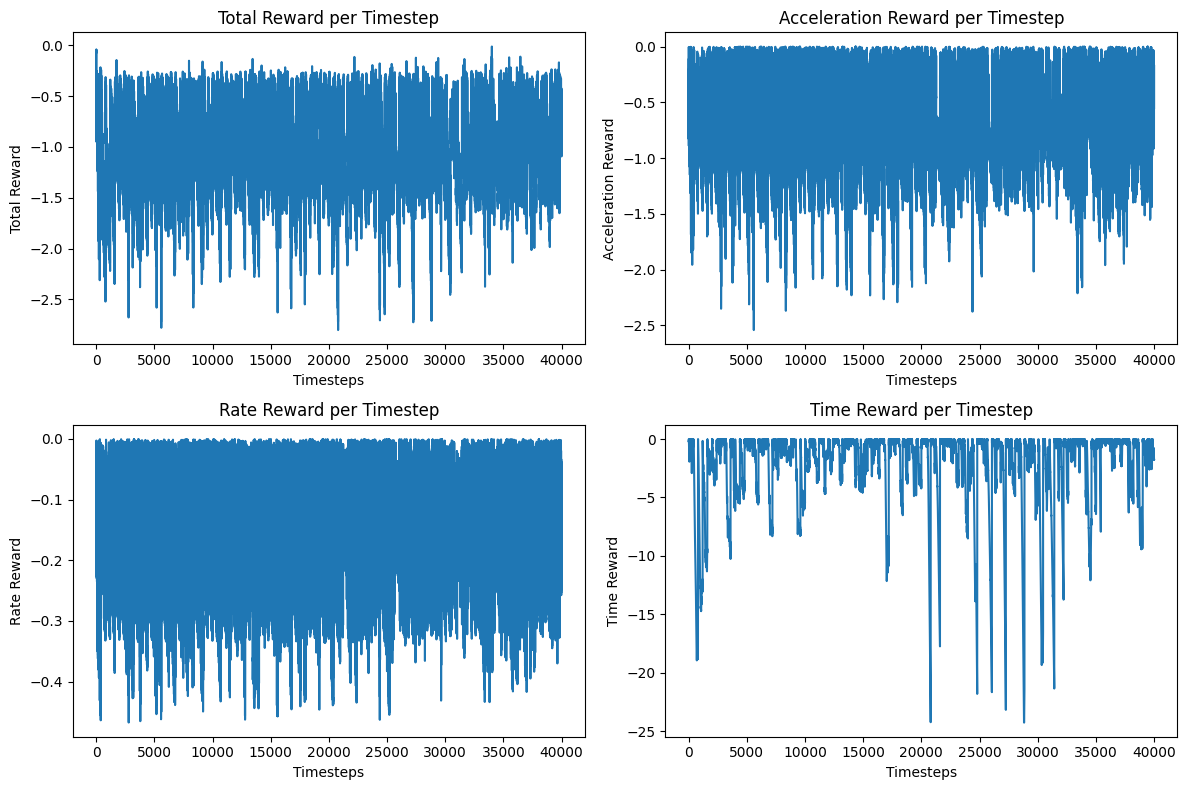

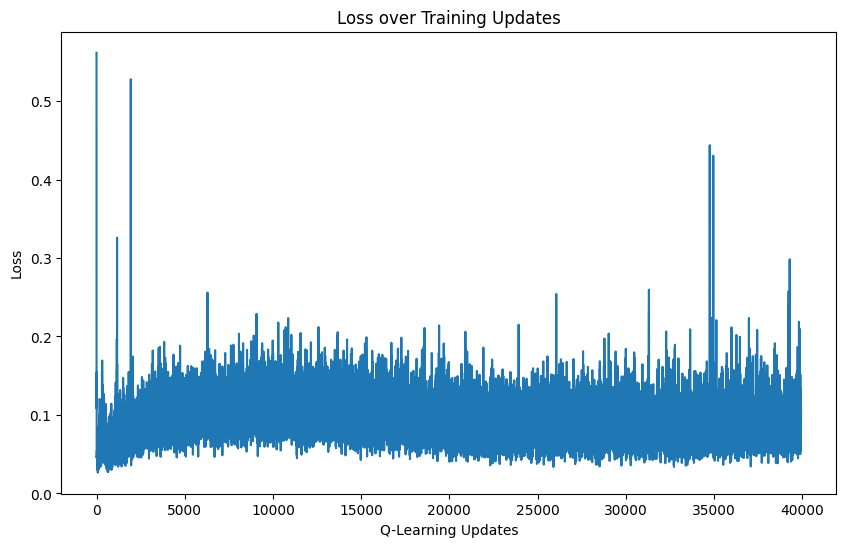

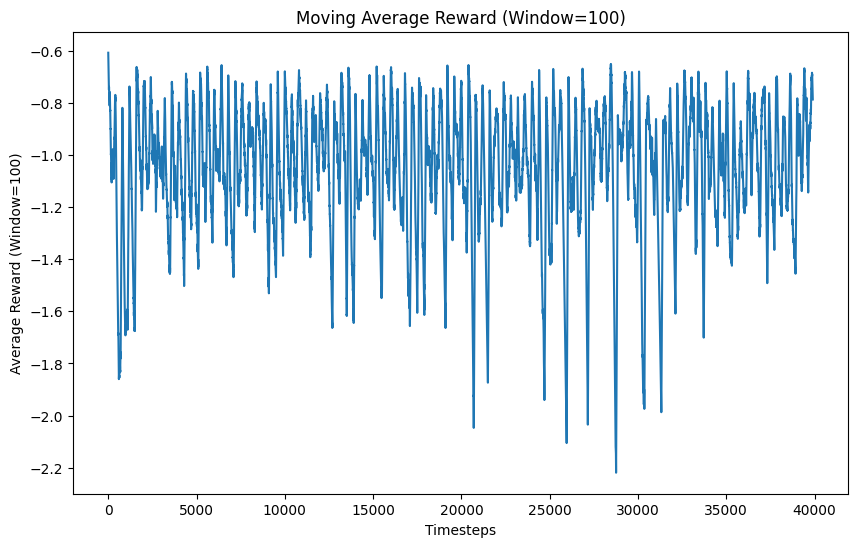

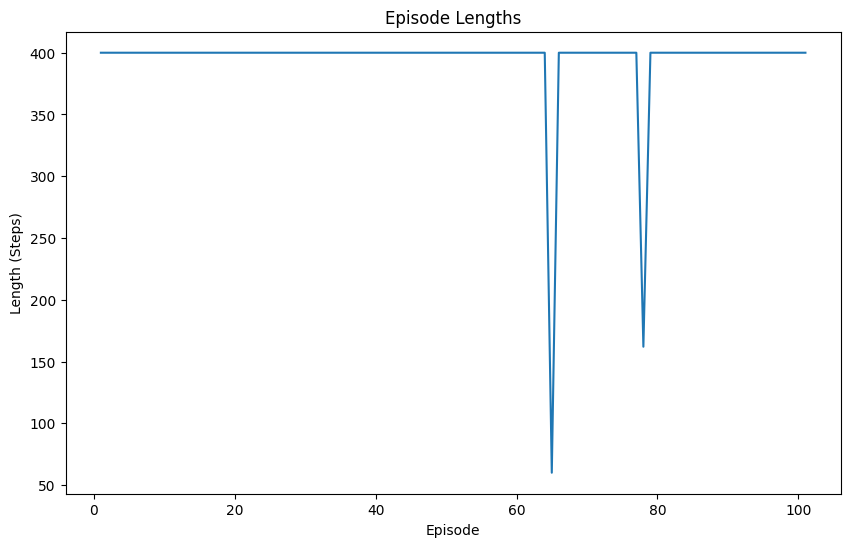

Plots saved at timestep 40000
Ep 102 | Steps:  178 | Avg Ep Len: 392.0 | Total Steps: 40000/40000 | Ep Return: -134.12 | Avg Return: -412.91 | Reward/Step: -0.753±0.194 | Epsilon: 0.050 | Buffer: 10000 | Loss: 0.10802164673805237
Recording final evaluation video...


KeyError: 'render_mode'

In [ ]:
################################################################################
"""Initialization with Video Recording Support"""
################################################################################
# Import additional libraries for video recording
import imageio
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from IPython.display import display
from IPython import display as ipythondisplay
import os

# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Set initial Input variables using the gap, current velocity, and relative lead velocity
input_variables = [lead_position_idm, ego_velocity_idm, lead_velocity_idm]

# Setup the IDM Model for Longitudinal control
ego_vehicle_idm = IDM(desired_parameters, control_parameters)

# Agent Initialization
total_steps_taken = 0
lr = 0.01  # Reduced learning rate
gamma = 0.99  # Higher discount factor for better long-term rewards

# Reasonable hyperparameter sizes
buffer_size = int(1e4)  # 100k buffer
batch_size = 64  # Standard batch size
max_timesteps = int(4e4)  # 40k total timesteps

# NEW: Soft update parameters
tau = 0.0005  # Small value for soft updates (typically between 0.001 and 0.1)
update_target_freq_steps = 1  # Update softly every step

plot_freq_steps = 5000  # Plot every 5000 timesteps
video_freq_steps = 5000  # Record video every 5000 steps
max_video_length = 500  # Maximum number of frames per video (to avoid very long videos)

# Epsilon-Greedy Parameters
epsilon_start = 0.5
epsilon_end = 0.05
epsilon_decay_steps = int(1e4)  # 20k steps for decay
epsilon = epsilon_start

# Tracking for performance
timestep_rewards = []  # Store rewards by timestep
timestep_acce_rewards = []  # Store acceleration rewards
timestep_rate_rewards = []  # Store rate rewards
timestep_time_rewards = []  # Store time rewards
global_returns = []  # Cumulative return tracking
loss_history = []  # Loss values
timesteps_list = []  # Track timesteps for plotting
episode_lengths = []  # Track episode lengths
episode_indices = []  # Track episode indices for plotting

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)

# Initialize Buffer
buffer = Experience_Buffer(buffer_size)

# Initialize State Normalizer
normalizer = StateNormalizer(size=state_dim, device=device)
# Update the normalizer with initial state to start populating statistics
normalizer.update_from_dict(agent_state)

# Setup Lateral Control Agent
target_network = Agent(state_dim).to(device)
policy_network = Agent(state_dim).to(device)

# Initialize target network
target_network.load_state_dict(policy_network.state_dict())

# Loss and Criterion Initialization
policy_optimizer = torch.optim.Adam(policy_network.parameters(), lr=lr)
policy_loss_fn = nn.MSELoss()

# Create directories for saved data
os.makedirs("training_plots", exist_ok=True)
os.makedirs("training_videos", exist_ok=True)

# NEW: Define a function for soft updates of target networks
def soft_update(target, source, tau):
    """
    Perform soft update on target network parameters
    target = (1-tau)*target + tau*source
    """
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + source_param.data * tau)

# Define a function to create a video only when needed during training
class VideoRecorder:
    def __init__(self, video_path, max_frames=500):
        self.video_path = video_path
        self.frames = []
        self.max_frames = max_frames
        self.recording = False
        self.step_count = 0
        self.episode_reward = 0.0

    def start_recording(self):
        """Start recording frames"""
        self.recording = True
        self.frames = []
        self.step_count = 0
        self.episode_reward = 0.0
        print(f"Started recording to {self.video_path}")

    def add_frame(self, env, reward=0.0):
        """Add a frame to the video if recording is active"""
        if not self.recording:
            return

        if self.step_count >= self.max_frames:
            self.stop_recording()
            return

        # Render current frame and add to frame list
        frame = env.render()
        self.frames.append(frame)
        self.episode_reward += reward
        self.step_count += 1

    def stop_recording(self):
        """Stop recording and save the video"""
        if not self.recording or len(self.frames) == 0:
            self.recording = False
            return None, None

        # Save video
        imageio.mimsave(self.video_path, self.frames, fps=15)
        self.recording = False

        # Return stats
        stats_text = f"Steps: {self.step_count}, Reward: {self.episode_reward:.2f}"

        print(f"Video saved to {self.video_path} - {stats_text}")
        return self.video_path, stats_text

################################################################################
"""Training & Testing Loop"""
################################################################################
print("Starting training loop...")
print(f"Device: {device}, Buffer Size: {buffer_size}, Batch Size: {batch_size}")
print(f"Epsilon Start: {epsilon_start}, Epsilon End: {epsilon_end}, Decay Steps: {epsilon_decay_steps}")
print(f"Learning Rate: {lr}, Gamma: {gamma}")
print(f"SOFT UPDATES: Tau = {tau}, Update Frequency: {update_target_freq_steps} steps")
print(f"Max Timesteps: {max_timesteps}")
print(f"Video Recording: Every {video_freq_steps} steps")
print("=" * 80)

# Track episode count
episode_count = 0

# Track average episode length for reporting
avg_ep_length = 0

# Track episode-specific rewards for calculating statistics
episode_rewards_list = []

# Initialize video recorder (but not recording yet)
video_recorder = None

# Continue until we reach the maximum number of timesteps
while total_steps_taken < max_timesteps:
    episode_count += 1

    # Reset environment and state manager
    obs, _ = env.reset()
    state_manager = ENV(obs, 0.0)

    # Initial state information
    ego_state_idm = state_manager.ego_state_idm()
    lead_state = state_manager.longitudinal_lead_state()
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    # Update normalizer with initial state
    normalizer.update_from_dict(agent_state)

    # Update IDM inputs based on initial state
    gap = lead_state['x']
    delta_velocity = lead_state['vx']
    input_variables = [gap, ego_state_idm['vx'], delta_velocity]

    episode_step = 0
    episode_return = 0.0
    done = False

    # Check if we need to start recording this episode
    # Start recording if we're near a video recording milestone
    should_record_this_episode = (
        total_steps_taken // video_freq_steps <
        (total_steps_taken + episode_step + 1) // video_freq_steps
    )

    if should_record_this_episode:
        # Switch rendering mode to rgb_array temporarily - save original mode first
        # Note: We don't create a new environment, instead we switch rendering mode
        original_render_mode = env.unwrapped.config["render_mode"]
        env.unwrapped.config["render_mode"] = "rgb_array"

        # Create video recorder for this episode
        video_path = f"training_videos/agent_video_step_{total_steps_taken + 1}.mp4"
        video_recorder = VideoRecorder(video_path, max_frames=max_video_length)
        video_recorder.start_recording()

        # Record initial frame
        video_recorder.add_frame(env)

    # Track rewards for this episode specifically
    current_episode_rewards = []

    # Run until episode terminates or we hit max timesteps
    while not done and total_steps_taken < max_timesteps:
        episode_step += 1
        total_steps_taken += 1
        timesteps_list.append(total_steps_taken)

        # Recompute gap
        gap = lead_state['x']

        ########################################################################
        """Action Preparation"""
        ########################################################################
        gap_control = Gap_Controller(obs, following_gap_threshold=30)
        activated_target_lane = gap_control.lane_checker()

        # Determine target lane
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        # Update the normalizer with the current state
        normalizer.update_from_dict(agent_state)

        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            # Exploration: choose random action
            agent_action = np.random.uniform(-1.0, 1.0)  # Random action between -1 and 1
        else:
            # Exploitation: choose best action according to policy
            with torch.no_grad():
                state_tensor = normalizer.normalize_dict_to_tensor(agent_state)
                agent_action = policy_network.action(state_tensor).item()

        # Store prior state for buffer
        old_state = agent_state
        obs_old = obs

        # IDM Longitudinal Control
        idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)
        longitudinal_control = idm_acceleration

        # Transform agent action to steering angle
        lateral_control = state_manager.steering_angle(agent_action, L)

        # Combine longitudinal and lateral actions
        action = [longitudinal_control, lateral_control]

        ########################################################################
        """Data Collection"""
        ########################################################################
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated

        # Update state manager with new observation and applied longitudinal control
        state_manager = ENV(obs, longitudinal_control)

        # Compute reward based on the new state
        reward_components = state_manager.reward_function(obs_old, obs, target_id)
        reward = reward_components[0]

        # Record frame if we're recording this episode
        if video_recorder and video_recorder.recording:
            video_recorder.add_frame(env, reward)

        # Add this reward to the current episode's rewards
        current_episode_rewards.append(reward)

        # Track rewards for each component
        timestep_rewards.append(reward)
        timestep_acce_rewards.append(reward_components[1])  # Acceleration reward
        timestep_rate_rewards.append(reward_components[2])  # Rate reward
        timestep_time_rewards.append(reward_components[3])  # Time reward

        # Update episode return
        episode_return += reward

        ########################################################################
        """Update IDM Controller Inputs for next step"""
        ########################################################################
        ego_state_idm = state_manager.ego_state_idm()
        lead_state = state_manager.longitudinal_lead_state()
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        # Update the normalizer with the new state
        normalizer.update_from_dict(agent_state)

        gap = lead_state['x']
        delta_velocity = lead_state['vx']
        input_variables = [gap, ego_state_idm['vx'], delta_velocity]

        # Convert state dictionaries to vectors before adding to buffer
        old_state_vec = normalizer._state_dict_to_vector(old_state)
        new_state_vec = normalizer._state_dict_to_vector(agent_state)

        # Update experience buffer with vector representations
        terminal_flag = 1.0 if done else 0.0
        buffer.add(old_state_vec, agent_action, reward, new_state_vec, terminal_flag)

        ########################################################################
        """Q-Learning Update"""
        ########################################################################
        if buffer.size() >= batch_size:
            # Print a message when training is about to start for the first time
            if len(loss_history) == 0:
                print("\n" + "=" * 50)
                print(f"Buffer filled with {buffer.size()} experiences. Starting Q-learning updates...")
                print("=" * 50 + "\n")

            rand_experience = buffer.sample_experience(batch_size=batch_size, device=device)
            states, actions_t, rewards_t, next_states, terminals_t = rand_experience

            # Normalize states and next_states
            states_normalized = normalizer.normalize_batch_tensor(states)
            next_states_normalized = normalizer.normalize_batch_tensor(next_states)

            # Use normalized states for Q-value computation
            current_q_values = policy_network(states_normalized, actions_t, terminals_t)

            with torch.no_grad():
                target_network.eval()
                next_act = target_network.action(states_normalized)
                max_next_q_values = target_network(states_normalized, next_act, terminals_t)

            target_q_values = rewards_t + gamma * max_next_q_values * (1.0 - terminals_t)
            loss = policy_loss_fn(current_q_values, target_q_values)
            loss_history.append(loss.item())

            policy_optimizer.zero_grad()
            loss.backward()
            policy_optimizer.step()

            # NEW: Apply soft update to target network if it's time
            if total_steps_taken % update_target_freq_steps == 0:
                soft_update(target_network, policy_network, tau)

                # Log soft update at milestone steps
                if total_steps_taken % 5000 == 0:
                    print(f"**** Soft target network update at timestep {total_steps_taken} (tau={tau}) ****")

            # Update epsilon with decay
            epsilon = max(
                epsilon_end,
                epsilon_start - (total_steps_taken * (epsilon_start - epsilon_end) / epsilon_decay_steps)
            )

            # Provide occasional update on training progress in the new format
            if total_steps_taken % 1000 == 0:
                avg_loss = np.mean(loss_history[-100:]) if len(loss_history) >= 100 else np.mean(loss_history)
                print(f"Step: {total_steps_taken:5d}/{max_timesteps} | Recent Avg Loss: {avg_loss:.6f} | Epsilon: {epsilon:.3f}")

        # Check if we should start recording at a specific step
        if total_steps_taken % video_freq_steps == 0 and total_steps_taken > 0 and (not video_recorder or not video_recorder.recording):
            # If we hit exactly the video recording step and we're not already recording
            print(f"Recording evaluation video at step {total_steps_taken}...")

            # We'll handle this at the start of the next episode to avoid disrupting the current one
            # Flag is set above when starting a new episode

        # Plot results based on timesteps
        if total_steps_taken % plot_freq_steps == 0 and total_steps_taken > 0:
            # Create plot directory if it doesn't exist
            plot_dir = "training_plots"
            if not os.path.exists(plot_dir):
                os.makedirs(plot_dir)

            # Plot reward components
            plt.figure(figsize=(12, 8))

            # Plot total rewards
            plt.subplot(2, 2, 1)
            plt.plot(timesteps_list, timestep_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Total Reward")
            plt.title("Total Reward per Timestep")

            # Plot acceleration rewards
            plt.subplot(2, 2, 2)
            plt.plot(timesteps_list, timestep_acce_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Acceleration Reward")
            plt.title("Acceleration Reward per Timestep")

            # Plot rate rewards
            plt.subplot(2, 2, 3)
            plt.plot(timesteps_list, timestep_rate_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Rate Reward")
            plt.title("Rate Reward per Timestep")

            # Plot time rewards
            plt.subplot(2, 2, 4)
            plt.plot(timesteps_list, timestep_time_rewards)
            plt.xlabel("Timesteps")
            plt.ylabel("Time Reward")
            plt.title("Time Reward per Timestep")

            plt.tight_layout()
            plt.savefig(f"{plot_dir}/rewards_timestep_{total_steps_taken}.png")
            plt.show()
            plt.close()

            # Plot loss history if we have losses
            if len(loss_history) > 0:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(loss_history)), loss_history)
                plt.xlabel("Q-Learning Updates")
                plt.ylabel("Loss")
                plt.title("Loss over Training Updates")
                plt.savefig(f"{plot_dir}/loss_timestep_{total_steps_taken}.png")
                plt.show()
                plt.close()

            # Plot moving average of rewards (with window of 100)
            if len(timestep_rewards) > 100:
                plt.figure(figsize=(10, 6))
                window_size = 100
                moving_avg = np.convolve(timestep_rewards, np.ones(window_size)/window_size, mode='valid')
                plt.plot(range(len(moving_avg)), moving_avg)
                plt.xlabel("Timesteps")
                plt.ylabel(f"Average Reward (Window={window_size})")
                plt.title(f"Moving Average Reward (Window={window_size})")
                plt.savefig(f"{plot_dir}/moving_avg_reward_timestep_{total_steps_taken}.png")
                plt.show()
                plt.close()

            # Plot episode lengths if we have episodes
            if len(episode_lengths) > 0:
                plt.figure(figsize=(10, 6))
                plt.plot(episode_indices, episode_lengths)
                plt.xlabel("Episode")
                plt.ylabel("Length (Steps)")
                plt.title("Episode Lengths")
                plt.savefig(f"{plot_dir}/episode_lengths_{total_steps_taken}.png")
                plt.show()
                plt.close()

            print(f"Plots saved at timestep {total_steps_taken}")

    # End of episode

    # Finalize video recording if we were recording this episode
    if video_recorder and video_recorder.recording:
        video_path, stats = video_recorder.stop_recording()
        # Reset rendering mode back to original
        env.unwrapped.config["render_mode"] = original_render_mode

        # Display the video in the notebook if in interactive mode
        try:
            from IPython.display import Video
            display(Video(video_path, embed=True, width=800))
        except:
            print("Video created but couldn't be displayed in the notebook.")

        # Clear the video recorder
        video_recorder = None

    global_returns.append(episode_return)
    episode_lengths.append(episode_step)
    episode_indices.append(episode_count)

    # Store this episode's rewards
    episode_rewards_list.append(current_episode_rewards)

    # Calculate average episode length
    avg_ep_length = np.mean(episode_lengths[-100:]) if len(episode_lengths) >= 100 else np.mean(episode_lengths)

    # Get average return from recent episodes
    avg_return = np.mean(global_returns[-100:]) if len(global_returns) >= 100 else np.mean(global_returns)

    # Get most recent loss value
    last_loss = loss_history[-1] if loss_history else "N/A"

    # Calculate average and standard deviation of reward per timestep for this episode
    avg_reward_per_step = np.mean(current_episode_rewards)
    std_reward_per_step = np.std(current_episode_rewards)

    # Print the progress report with enhanced statistics
    print(f"Ep {episode_count:3d} | Steps: {episode_step:4d} | Avg Ep Len: {avg_ep_length:.1f} | Total Steps: {total_steps_taken:5d}/{max_timesteps} | "
          f"Ep Return: {episode_return:6.2f} | Avg Return: {avg_return:6.2f} | "
          f"Reward/Step: {avg_reward_per_step:.3f}±{std_reward_per_step:.3f} | "
          f"Epsilon: {epsilon:.3f} | Buffer: {buffer.size():5d} | Loss: {last_loss}")

# Record a final video after training is complete
final_video_path = "training_videos/final_agent_performance.mp4"
print("Recording final evaluation video...")

# Switch to rendering mode for final video
original_render_mode = env.unwrapped.config["render_mode"]
env.unwrapped.config["render_mode"] = "rgb_array"

# Create recorder for final video
final_recorder = VideoRecorder(final_video_path, max_frames=max_video_length)
final_recorder.start_recording()

# Reset environment for final video
obs, _ = env.reset()
state_manager = ENV(obs, 0.0)

# Get initial state information
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()
gap = lead_state['x']
delta_velocity = lead_state['vx']
input_variables = [gap, ego_state_idm['vx'], delta_velocity]

# Record initial frame
final_recorder.add_frame(env)

# Run until episode terminates or max length reached
done = False
while not done and final_recorder.step_count < max_video_length:
    # Determine target lane
    gap_control = Gap_Controller(obs, following_gap_threshold=30)
    target_id = gap_control.lane_checker()

    # Get agent state and normalize
    agent_state = state_manager.ego_state_agent(target_id=target_id)
    state_tensor = normalizer.normalize_dict_to_tensor(agent_state)

    # Get action from policy (no exploration for final video)
    with torch.no_grad():
        agent_action = policy_network.action(state_tensor).item()

    # IDM Longitudinal Control
    idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)
    longitudinal_control = idm_acceleration

    # Transform agent action to steering angle
    lateral_control = state_manager.steering_angle(agent_action, L)

    # Combine actions
    action = [longitudinal_control, lateral_control]

    # Execute action
    obs, reward, done, truncated, info = env.step(action)
    done = done or truncated

    # Record frame
    final_recorder.add_frame(env, reward)

    # Update for next step
    state_manager = ENV(obs, longitudinal_control)
    ego_state_idm = state_manager.ego_state_idm()
    lead_state = state_manager.longitudinal_lead_state()

    gap = lead_state['x']
    delta_velocity = lead_state['vx']
    input_variables = [gap, ego_state_idm['vx'], delta_velocity]

# Finalize the video
video_path, stats = final_recorder.stop_recording()

# Reset rendering mode
env.unwrapped.config["render_mode"] = original_render_mode

# Try to display the final video
try:
    from IPython.display import Video
    display(Video(final_video_path, embed=True, width=800))
except:
    print("Final video created but couldn't be displayed in the notebook.")

# Final plots after training is complete
print("\nTraining complete! Creating final plots...")

# Plot all rewards in separate figures
plt.figure(figsize=(10, 6))
plt.plot(timesteps_list, timestep_rewards)
plt.xlabel("Timesteps")
plt.ylabel("Total Reward")
plt.title("Total Reward per Timestep")
plt.savefig("final_total_rewards.png")
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(timesteps_list, timestep_acce_rewards)
plt.xlabel("Timesteps")
plt.ylabel("Acceleration Reward")
plt.title("Acceleration Reward per Timestep")
plt.savefig("final_acce_rewards.png")
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(timesteps_list, timestep_rate_rewards)
plt.xlabel("Timesteps")
plt.ylabel("Rate Reward")
plt.title("Rate Reward per Timestep")
plt.savefig("final_rate_rewards.png")
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(timesteps_list, timestep_time_rewards)
plt.xlabel("Timesteps")
plt.ylabel("Time Reward")
plt.title("Time Reward per Timestep")
plt.savefig("final_time_rewards.png")
plt.show()
plt.close()

# Plot loss history
if len(loss_history) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(loss_history)), loss_history)
    plt.xlabel("Q-Learning Updates")
    plt.ylabel("Loss")
    plt.title("Loss over Training Updates")
    plt.savefig("final_loss.png")
    plt.show()
    plt.close()

# Plot episode returns
plt.figure(figsize=(10, 6))
plt.plot(range(len(global_returns)), global_returns)
plt.xlabel("Episode")
plt.ylabel("Episode Return")
plt.title("Episode Returns")
plt.savefig("final_episode_returns.png")
plt.show()
plt.close()

# Plot episode lengths
plt.figure(figsize=(10, 6))
plt.plot(episode_indices, episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Length (Steps)")
plt.title("Episode Lengths")
plt.savefig("final_episode_lengths.png")
plt.show()
plt.close()

print("Final plots saved!")
print(f"All videos saved in the 'training_videos' directory")